# AIML Assignment 2: Time Series Analysis on Pollutant Gases
## Problem Statement
![Air Pollution](https://assets.nrdc.org/sites/default/files/styles/header_background/public/health4_26_airpollguide_istock_2796602_900x600px.jpg?itok=vCwn8tgz)

Air pollution is a problem that affects major cities around the world. There are many different types of air pollutants, which usually come in the form of gases like carbon monoxide, carbon dioxide, sulfur dioxide, nitrogen oxides, CFCss, and other chemicals. 

Bad air quality in cities can lead to health problems for residents living there, including respiratory diseases and even death. In fact, according to the World Health Organisation, air pollution accounts for 4.2 million deaths every year [[1]](https://www.who.int/health-topics/air-pollution#tab=tab_1). To keep track of air pollution, governments invest heavily in sensors, which are used to measure the level of air pollution of different pollutants. However, good quality sensors are expensive, and thus governments rely on cheap sensors which have low accuracy. [[2]](https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=5536&context=sis_research)

Our task is to create a time series model that is capable of forecasting air pollution levels. If our model can forecast air pollution data with a reasonable accuracy, it would be a valuable tool (more accurate than low quality sensors) for health authorities to guage the impact of air pollution, and warn the public of any health threats. 

To be more concrete, our task is to predict the average sensor response of Carbon Monoxide, Non Metanic HydroCarbons, Nitrogen Oxides, and Ozone. (Note that sensor response is not the same as the concentration.)

### Carbon Monoxide (CO)
Carbon monoxide (CO)—a colorless, odorless, tasteless, and toxic air pollutant—is produced in the incomplete combustion of carbon-containing fuels, such as gasoline, natural gas, oil, coal, and wood. Breathing the high concentrations of CO typical of a polluted environment leads to reduced oxygen (O2) transport by hemoglobin and has health effects that include headaches, increased risk of chest pain for persons with heart disease, and impaired reaction timing. [[3]](https://www.nap.edu/read/10378/chapter/3)

## Data Understanding
The dataset appears to be sourced from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality), but with data downsampled from an hourly frequency to a daily frequency, and several features omitted. The description and date range of the data appears to match up, the scales of the data are the same,and even the method of marking missing values is the same. Furthermore, downsampling that dataset leads to a dataset that has a similar size as the one provided. 

If we make an assumption that the data set is the same, we can say that the data was collected from chemical sensor data collected over the course of March 2004 to February 2005. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub)

![Operation of a MOS Type Gas Sensor](https://www.figaro.co.jp/en/img/development/handoutai/shikumi.gif)

The sensors used are metal oxide sensors, which use a sensing layer, where gases are either absorbed or desorbed. This reaction causes a change in the conductivity of the material. [[4]](https://www.sciencedirect.com/science/article/abs/pii/S0925400507007691?via%3Dihub). The sensor device then uses this reading to estimate the concentration of that particular gas in the surroundings.

Our dataset contains the following attributes:
| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants. Note that the concentration for Carbon Monoxide would be in a different unit |

Our target attribute would be the `Value` attribute.
## References
- AIML Module Notes
- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. 
- Statsmodels Documentation
- Pandas documentation
- Scikit Learn documentation
- Wiley Data Analyst Time Series and Forecasting Notes
- [World Health Organisation](https://www.who.int/health-topics/air-pollution#tab=tab_1)
- MAAH, Balz; ZHOU, Zimu; and THIELE, Lothar. A survey on sensor calibration in air pollution monitoring 
deployments. (2018). IEEE Internet of Things. 5, (6), 4857-4870. Research Collection School Of 
Information Systems. 
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
- [S. De Vito, E. Massera, M. Piga, L. Martinotto, G. Di Francia,
On field calibration of an electronic nose for benzene estimation in an urban pollution monitoring scenario](https://www.researchgate.net/publication/235641830_On_field_calibration_of_an_electronic_nose_for_benzene_estimation_in_an_urban_pollution_monitoring_scenario)
- [Climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy)
- [Nitrogen Oxide Emission Trends for Italy](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- [NOx Emissions - European Environment Agency](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)
- [Effect of Environmental Temperature and Humidity
on Different Metal Oxide Gas Sensors at Various
Gas Concentration Levels, Abdulnasser Nabil Abdullah et al 2020 IOP Conf. Ser.: Mater. Sci. Eng. 864
012152](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf)
- [Choosing the order of an ARIMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html#the-acf-and-pacf-function)
- [Using Pearson Correlation Correctly With Time Series](https://stats.stackexchange.com/questions/133155/how-to-use-pearson-correlation-correctly-with-time-series)

## Library Imports

In [1]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models

# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Data Ingestion
We will start out by loading in our data. We must take note here that the date formatting of the data does not follow the standard Pandas convention. As such, we must specify the date formatting to convert the date attribute to a datetime.

Since many Pandas time series methods only work if the index of our data is a time series, we will set the date attribute as the index.

Also, we will set all -200 values as missing values, as specified in the dataset source.

In [2]:
df = pd.read_csv("train.csv", na_values=[-200])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df.head()

T         RH Gas        Value
Date                                             
2004-03-10  12.020833  54.883334  CO  1316.500000
2004-03-11   9.833333  64.069791  CO  1244.062500
2004-03-12  11.292708  51.107292  CO  1281.562500
2004-03-13  12.866319  51.530903  CO  1330.555556
2004-03-14  16.016667  48.843750  CO  1360.927083

### Pivoting from Long to Wide Format
The form of our data is in a long format. For easier analysis later, we will pivot the data to a wide format, with a column for each row.

In [3]:
df_pivot = pd.pivot(df, values="Value", columns="Gas")
df_pivot[["T", "RH"]] = df[["T", "RH"]].groupby(df.index).mean()

## Exploratory Data Analysis

We then perform an exploratory data analysis of our data. 

### What do we want to find out?
#### General Dataset Information
- How many rows of data are there?
- What is the frequency of the time series data?
- How many features are there, and what do they mean?
- What are the data types of each attribute, and are they correctly represented?

#### Missing Values
- How many missing values are there?
- Why are there missing values?
- What should be done about the missing values?

#### Distribution of Data
- What does the distribution of our data look like, and what does it say about the data?

#### Outlier Analysis
- How many outliers are there in the data?
- Where are the outliers in the data?
- What should be done about outliers?
#### Correlation
- What are the relationships between the various variables?

#### Time Series

- What can be said about the trend and seasonality of the data?
- Is the data stationary?

### General Dataset Information

#### How many rows of data are there?

In [4]:
rows, cols = df.shape
print(f"There are {rows} rows and {cols} attributes in the dataset.")

There are 1312 rows and 4 attributes in the dataset.


In [5]:
rows, cols = df_pivot.shape
print(f"There are {rows} rows and {cols} attributes in the pivoted dataset.")

There are 328 rows and 6 attributes in the pivoted dataset.


#### What is the frequency of the time series data?

In [6]:
df_pivot.index

DatetimeIndex(['2004-03-10', '2004-03-11', '2004-03-12', '2004-03-13',
               '2004-03-14', '2004-03-15', '2004-03-16', '2004-03-17',
               '2004-03-18', '2004-03-19',
               ...
               '2005-01-22', '2005-01-23', '2005-01-24', '2005-01-25',
               '2005-01-26', '2005-01-27', '2005-01-28', '2005-01-29',
               '2005-01-30', '2005-01-31'],
              dtype='datetime64[ns]', name='Date', length=328, freq=None)

There is not explicitly stated frequency. However, we suspect it is daily. We will need to verify this.

In [7]:
len(df_pivot) - len(df_pivot.asfreq("D"))

0

Since `.asfreq("D")` did not make any extra rows in the data, this confirms our hypothesis of a daily frequency.

In [8]:
df_pivot = df_pivot.asfreq("D") # explicitly state a daily frequency

#### How many features are there and what do they mean?

Our dataset contains the following attributes:
| Attribute | Description |
|---|---|
| Date | Day/Month/Year Format, which is different from default Pandas format |
| T | Temperature in Degree Celcius |
| RH | Relative Humidity (%) |
| Gas | Type of Gas Measured: CO (Carbon Monoxide), NMHC (Non Metanic HydroCarbons), NOx (Nitrogen Oxides), O3 (Ozone) |
| Value | Daily Averaged Estimated Concentration of Pollutants in micrograms/milligrams per cubic meter. Note that the concentration for Carbon Monoxide would be in a different unit (milligrams) |

#### What are the data types of each attribute, and are they correctly represented?

In [9]:
df.dtypes

T        float64
RH       float64
Gas       object
Value    float64
dtype: object

We observe no irregularities with regards to the data type.

### Missing Values

#### How many missing values are there?

In [10]:
df.isna().sum()

T        24
RH       24
Gas       0
Value    24
dtype: int64

In [11]:
df_pivot.isna().sum()

Gas
CO      6
NMHC    6
NOx     6
O3      6
T       6
RH      6
dtype: int64

In [12]:
df_pivot.isna().all(axis=1).sum()

6

It appears that there are exactly six days, where all the attributes are missing.

In [13]:
(df_pivot.isna().all(axis=1).sum() / len(df_pivot)) * 100

1.8292682926829267

This constitutes a very small percentage of our data.

#### Why are there missing values?

In [14]:
df_pivot[df_pivot.isna().any(axis=1)]

Gas         CO  NMHC  NOx  O3   T  RH
Date                                 
2004-06-20 NaN   NaN  NaN NaN NaN NaN
2004-08-27 NaN   NaN  NaN NaN NaN NaN
2004-12-15 NaN   NaN  NaN NaN NaN NaN
2004-12-16 NaN   NaN  NaN NaN NaN NaN
2005-01-03 NaN   NaN  NaN NaN NaN NaN
2005-01-04 NaN   NaN  NaN NaN NaN NaN

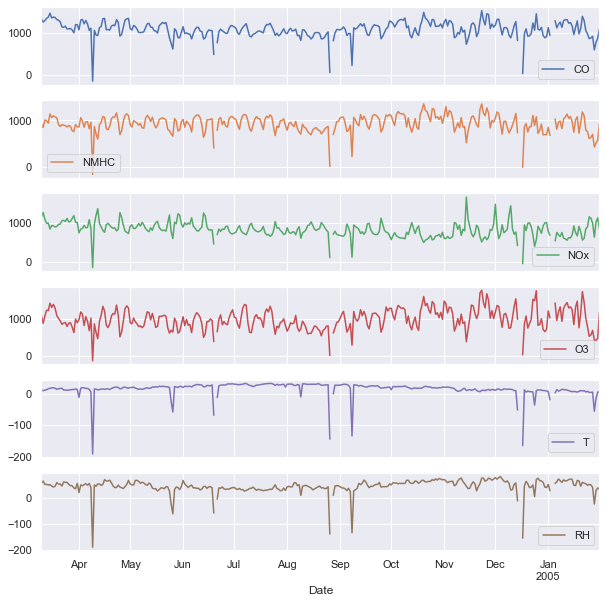

In [15]:
df_pivot.plot(subplots=True, figsize=(10, 10))
plt.show()

We note that days where the missing values do not appear to be related. For some of the days with missing values, we note that the days before and after them have some extreme values, such as extreme spikes.

One possible hypothesis is that the spikes indicate some problem with the sensor used, and thus, the sensors had to be sent for repairs, causing data to be unavailable in the meantime. This would indicate why all the sensors had missing datas on those days.

#### What should be done about missing values?

Based on our hypothesis, if the missing values are due to problems with the sensors that were detected, it may not be a good idea to immediately fill the missing values with the previous value, as it may be an outlier value.

Possible methods:
- Front fill, but mark and deal with outliers first

### Distribution of Data

#### What does the distribution of our data look like, and what does it say about the data?

In [16]:
df_pivot.describe()

Gas             CO         NMHC          NOx           O3           T  \
count   322.000000   322.000000   322.000000   322.000000  322.000000   
mean   1074.034862   932.706457   831.478477   997.677396   15.578425   
std     192.346012   184.942814   200.428180   287.769529   23.412864   
min    -142.666667  -153.458333  -155.583333  -143.697917 -191.164583   
25%     981.338542   839.421875   712.370660   809.098958   12.627083   
50%    1084.482639   948.649306   826.208333  1005.692708   18.993750   
75%    1188.539062  1061.109375   944.387153  1183.658854   25.714149   
max    1513.208333  1355.104167  1678.687500  1795.291667   32.997917   

Gas            RH  
count  322.000000  
mean    44.343425  
std     28.487081  
min   -188.839583  
25%     37.101042  
50%     46.452083  
75%     58.028386  
max     81.104167

- The mean temperature recorded is 15.57 Degrees Celcius, but the min temperature -191.164 degrees celcius. This appears to be an extreme outlier.
- The median temperature is higher than the mean temperature, suggesting a negatively skewed distribution.
- The temperatures seen are mostly consistent with the [climate of Italy](https://en.wikipedia.org/wiki/Climate_of_Italy). This suggests that the temperatures with extreme negative values are actually outliers (possibly sensor miscalibrations), and not the result of extreme cooling in the sensor device.
- The mean relative humidity is 44.34%, which is lower than the median relative humidity. This might suggest a negatively skewed distribution of the data.
- If relative humidity is in percentage, having a negative percentage relative humidity does not make sense. Consider that relative humidity is the **ratio of how much water vapour is in the air and how much water vapor the air could possibly contain at a given temperature**; How is it possible then that it is negative? Logically this must be an error (again, possibly a result of faulty sensors), and any negative values for Relative Humidity should be removed.
- Furthermore, according to the researchers who collected the data, the sensors used are only rated for a temperature of -20 to 50 degrees celcius, and a relative humidity of 10% to 90%. Hence, it is safe to consider any values out of this range as being inaccurate anyways.

![sensor specifications](sensor_specifications.png)

- In our data, we see that there are negative values for each gas as their min estimated concentration
- Recall that for the metal oxide sensors used to collect this data, we get these readings by measuring the change in resistance of the metal oxide material due to a chemical reaction between the metal oxide and the gas and using it to estimate the concentration of pollutants. Thus the "value" attribute in our data is supposed to be an estimated concentration in $\mu/m^3$ (for Nitrogen Oxides and Ozone), or $mg/m^3$ (for Carbon Monoxide)
- As such, a negative concentration does not make any sense. Given that the sensor is only giving a rough estimate of the concentration, it is highly possible that these negative values came about due to sensor errors. 
- The mean values are similar to their median, suggesting that the distribution is not highly skewed; The only outliers come from the negative values.
- Since the values are technically in different units, we may also want to perform scaling of our data.

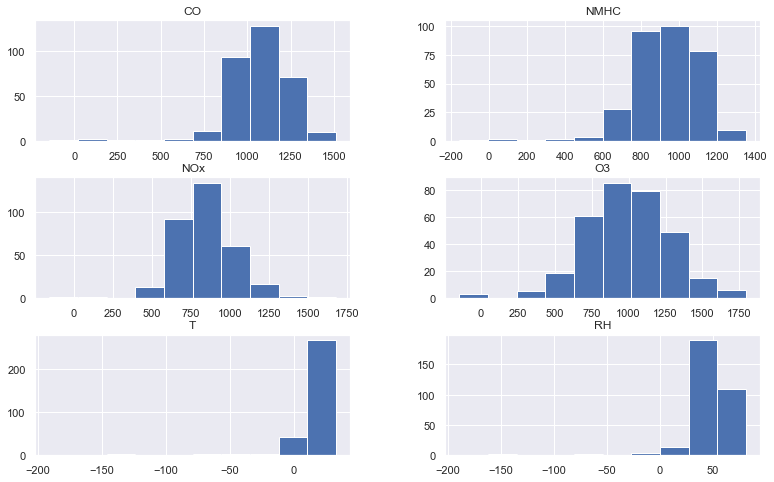

In [17]:
df_pivot.hist()
plt.show()

- We observe that the distribution of Temperature and Relative Humidity is negatively skewed, due to the outlier values
- The distribution of NOx and O3 appear to be more symmetrical
- Distribution of CO and NMHC is more negatively skewed, due to there being some outlier values.

### Outlier Analysis

From our previous analysis, we noted the presense of outliers in all numerical features. We had already come to a few conclusions based on our background research:
- These values are unnatural, and are impossible occurances in real life:
    - The freezing outlier temps are too cold for Italy's, and even too cold for the Artic
    - It is impossible for relative humidity to be negative
    - The sensors used to collect the data, are not rated for these extreme outlier temperatures/humdity
    - A negative concentration (which is what the sensors are trying to estimate), is also ridiculous. 
- Thus, we hypothesise that these come as a result of sensor calibration errors, resulting in a wrong sensor reading.

To test this hypothesis, we want to answer a few questions:
1. How many of these extreme outliers are there?
2. When do these outliers happen? Do they happen indepedently, or is there some pattern to the outlier data?

For this, we will use Tukey's Fences to denote any outliers. Recall that by this criterion, an outlier is any data that founds outside the range $[Q_1 - k(Q_3 - Q_1), Q_3 + k(Q_3 - Q_1)]$. We use Tukey's Fences, as this method is applicable to skewed data since it makes no distributional assumptions and it does not depend on a mean or standard 
deviation. In this case, we will look at the extreme outliers, setting $k=3$. We will also mark negative RH and Value as outliers, since in the context here, they are definitely wrong.

We also need to take note that for time series data, we cannot use future information to detect past outliers. Hence, we will detect outliers on a rolling basis.

In [18]:
df_outliers = df_pivot.copy(deep=True)

In [19]:
def mark_outliers(df, col, k=1.5, window=7):
    df_col = df[col].rolling(window)
    upper_quartile = df_col.quantile(.75)
    lower_quartile = df_col.quantile(.25)
    interquartille_range = upper_quartile - lower_quartile
    upper_fence = upper_quartile + (k * interquartille_range)
    lower_fence = lower_quartile - (k * interquartille_range)
    outliers = ~(df[col].between(lower_fence, upper_fence))
    return outliers

Our current outlier detection method also may miss out certain anomalies.

We want to ensure that any 'impossible' values are marked as outliers. These are values which could not possibly be 0, or are actually out of the operating range for the sensor, and thus the result may not be reliable.

In [20]:
additional_outlier_rules = {
        col : df_outliers[col] < 0 for col in ('CO', 'NMHC', 'NOx', 'O3')
} | {
    "T" : (df_outliers['T'] < -20) | (df_outliers['T'] > 50),
    "RH" : (df_outliers['RH'] < 10) | (df_outliers['RH'] > 90)
}

In [21]:
for col in df_outliers.columns:
    outliers = mark_outliers(df_outliers, col, k=3, window=7) # 1 Week Window
    df_outliers[f'Outlier ({col})'] = (outliers) | (additional_outlier_rules[col])
    

In [22]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].any(axis=1).sum()

72

In [23]:
df_outliers[filter(lambda x : x.startswith('Outlier'),df_outliers.columns)].sum()

Gas
Outlier (CO)      43
Outlier (NMHC)    42
Outlier (NOx)     49
Outlier (O3)      41
Outlier (T)       57
Outlier (RH)      51
dtype: int64

There are 72 rows with at least one outlier in total. Since there are at least >40 outliers for each column, it suggests that most days with outliers have more than one attribute with an outlier.

#### Where are the outliers in the data?

In [24]:
def plot_outlier(df, col_name, ax):
    outliers = df_outliers[df_outliers[f'Outlier ({col_name})'] == True]
    print(f"Number of Outliers for {col}:", len(outliers))
    df_outliers.plot(y=col_name, title=f"Outlier Plot of {col_name}", ax = ax)
    ax.scatter(x=outliers.index, y=outliers[col_name], color='r')

Number of Outliers for CO: 43
Number of Outliers for NMHC: 42
Number of Outliers for NOx: 49
Number of Outliers for O3: 41
Number of Outliers for T: 57
Number of Outliers for RH: 51


C:\Users\tienc\AppData\Local\Temp/ipykernel_11048/3075534334.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


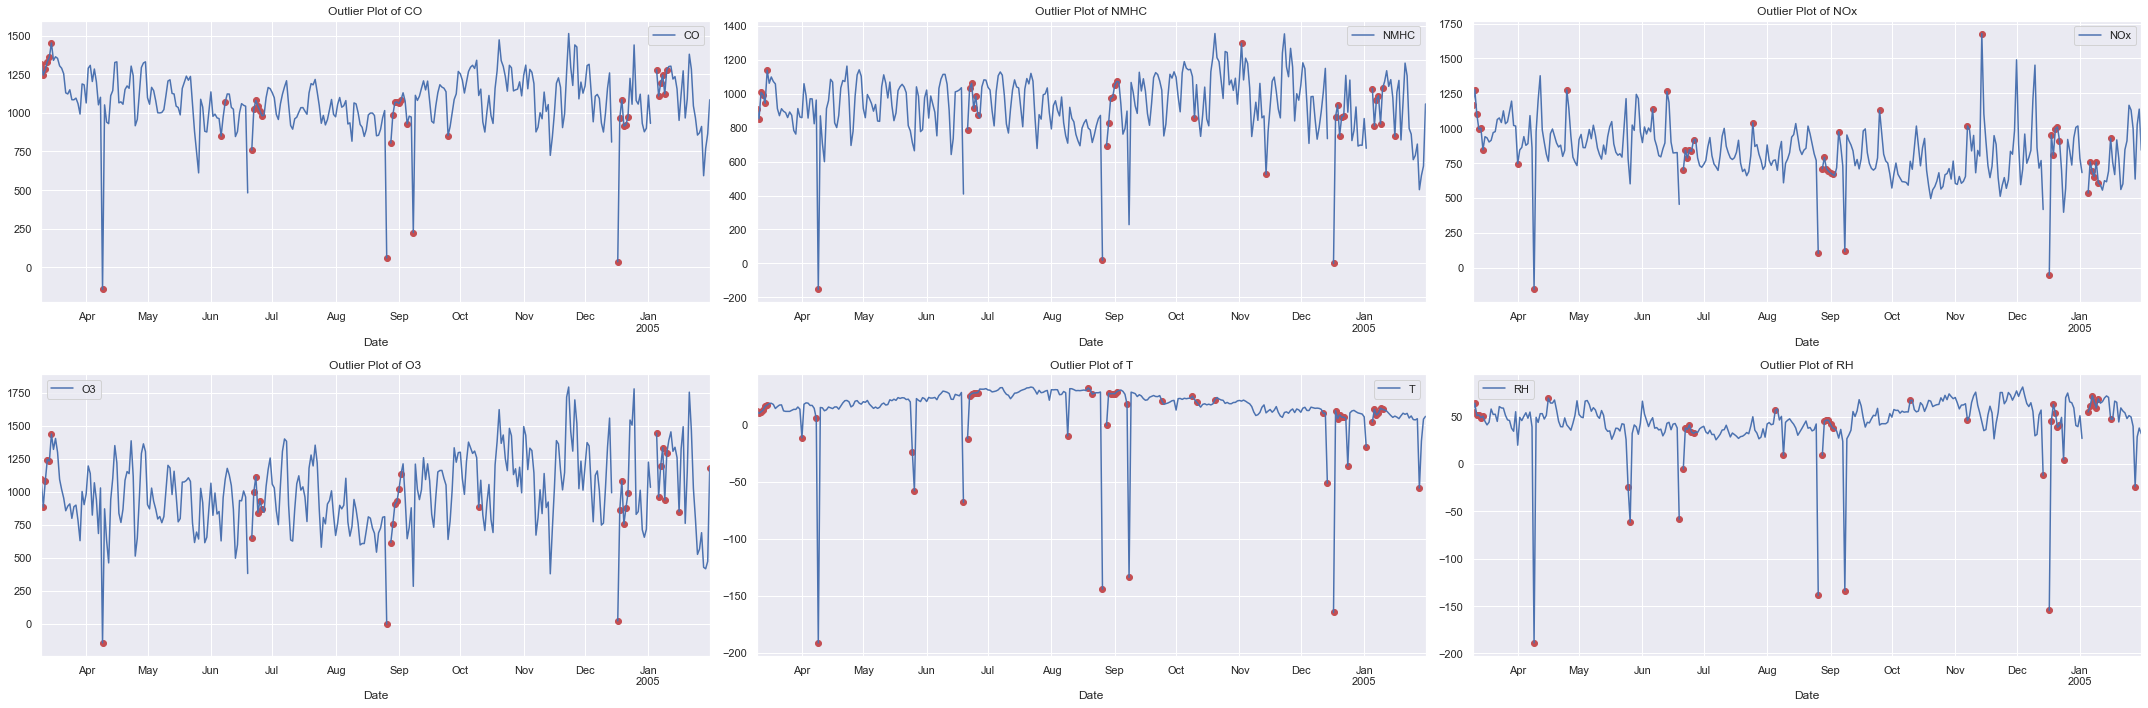

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(30, 10), tight_layout=True)

for ax, col in zip(axes.ravel(), df_pivot.columns):
    plot_outlier(df_outliers, col, ax)

fig.show()

- We note that the detected outliers appear to happen at similar points in time to outliers in other features

#### What should be done about outliers?

According to [research](https://iopscience.iop.org/article/10.1088/1757-899X/864/1/012152/pdf), when there are changes in the temperature and relative humidity, it causes a change in the resistance of the sensor, thus causing the readings to drift. This suggest that outside of the operating range of the sensors used (-20 to 50 degrees in Temp, and 10-90% relative humidity), the readings of the sensor would be less accurate. 

There are a few approaches we can take here:
- Ignore the outliers. But this is likely a bad idea, as at the very least, the outlier temperature and relative humidity are definitely wrong.
- Mark the outlier value, and  
    - Impute with the previous value
    - Impute with a rolling mean

For a start, we choose to ignore the extreme outliers, only cleaning the 'impossible' outliers first. Later on we will see what happens when extreme outliers are cleaned.

In [26]:
df_outliers.sum(axis=0)

Gas
CO                345839.225691
NMHC              300331.479173
NOx               267736.069443
O3                321252.121517
T                   5016.252777
RH                 14278.582988
Outlier (CO)          43.000000
Outlier (NMHC)        42.000000
Outlier (NOx)         49.000000
Outlier (O3)          41.000000
Outlier (T)           57.000000
Outlier (RH)          51.000000
dtype: float64

In [27]:
df_basic_clean = df_pivot.copy(deep=True)
for col in df_basic_clean.columns:
    outliers = additional_outlier_rules[col]
    df_basic_clean.loc[outliers, col] = np.nan
print("Before:", df_basic_clean.isna().sum())
df_basic_clean = df_basic_clean.ffill().bfill()
print("After:", df_basic_clean.isna().sum())


Before: Gas
CO       7
NMHC     8
NOx      8
O3       8
T       16
RH      19
dtype: int64
After: Gas
CO      0
NMHC    0
NOx     0
O3      0
T       0
RH      0
dtype: int64


### Correlation
#### What are the relationships between the various variables?

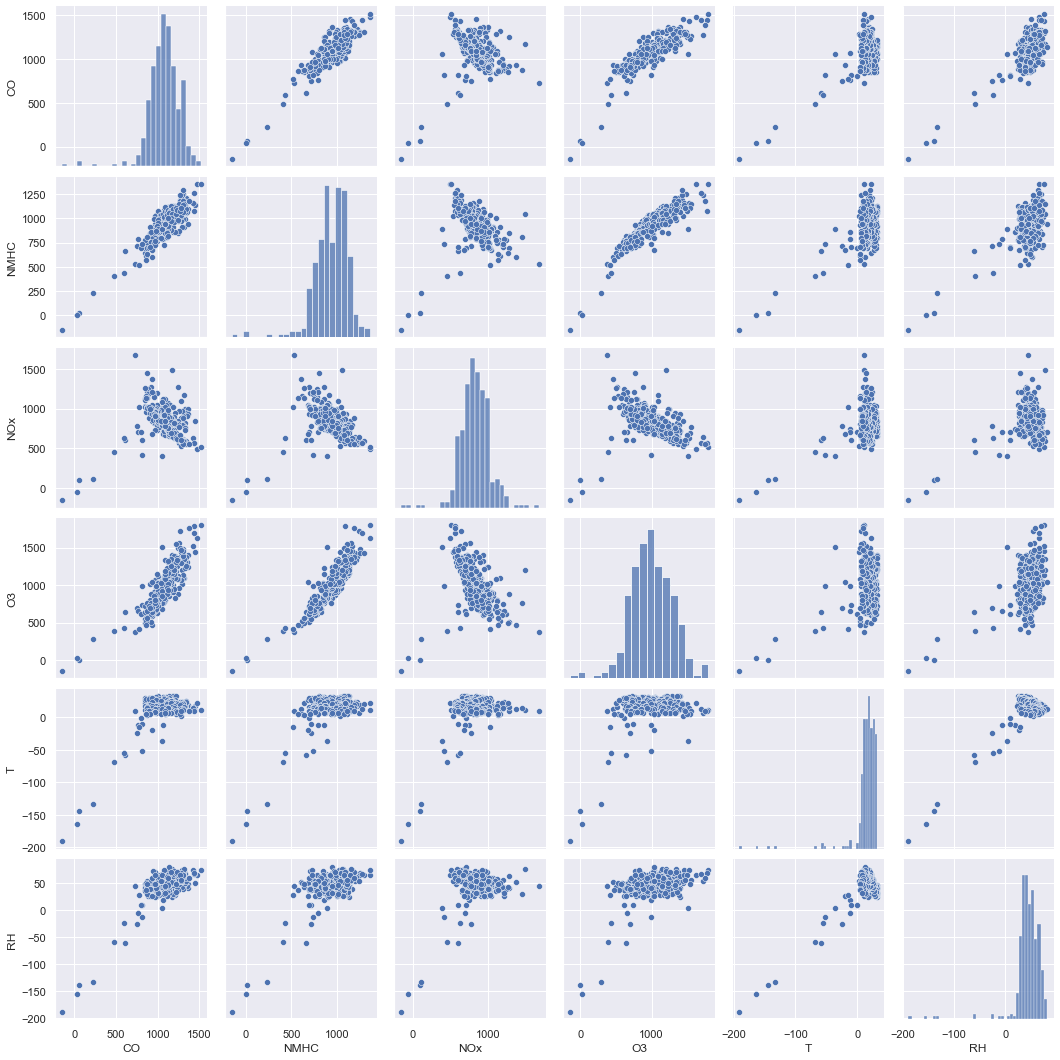

In [28]:
sns.pairplot(df_pivot)

We see that before we cleaned the data, there were many outliers, which do not follow the trend of the data.

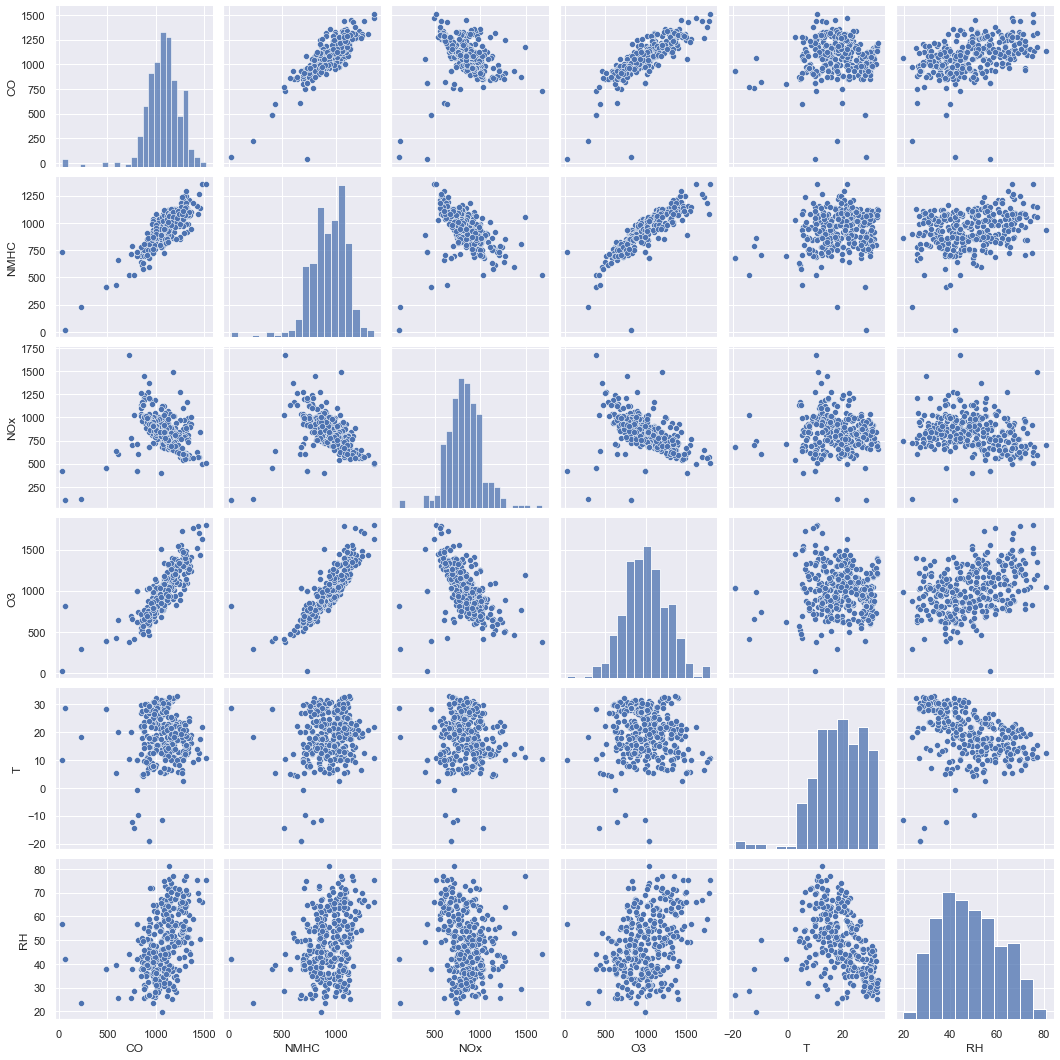

In [29]:
sns.pairplot(df_basic_clean)

To avoid recording spurious correlation (false correlation due to within-series dependence), we will instead calculate correlation based off the percentage change (the differenced data).

To calculate correlation, we use Pearson's correlation coefficient.

<AxesSubplot:xlabel='Gas', ylabel='Gas'>

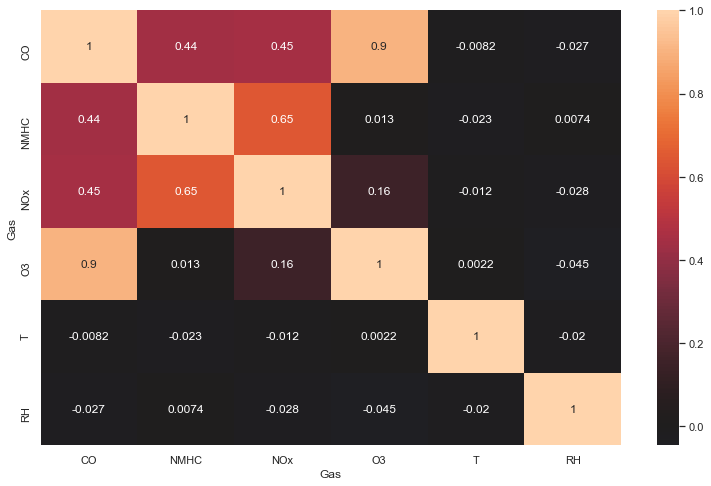

In [30]:
sns.heatmap(df_basic_clean.pct_change().corr(), annot=True, center=0)

- We observe that the change in CO levels is highly correlated with the change in Ozone (r=0.9) and NMHC (r=0.44) levels 

### Time Series

#### What can be said about the trend and seasonality of the data?

To have a clearer understanding of our data, we want to decompose the time series into it's components, which are: the Seasonal Component ($S_t$), the Trend-Cycle component ($T_t$), and the remainder components ($R_t$)

There are two ways which we can decompose our data, additively ($y_t = S_t + T_t + R_t$), or multiplicatively ($y_t = S_t \times T_t \times R_t$). Given that for most our our time series data (except that of Relative Humidity), the variance does not change as the mean changes, an additive model for decomposition makes the most sense. 

To decompose the data, we will use STL decomposition, due to it's advantages over classical decomposition methods. (it allows for the seasonal component to change over time, and is robust to outliers, which is important given that we showed earlier that unusual observations exist in the data). 

##### Temperature (T)

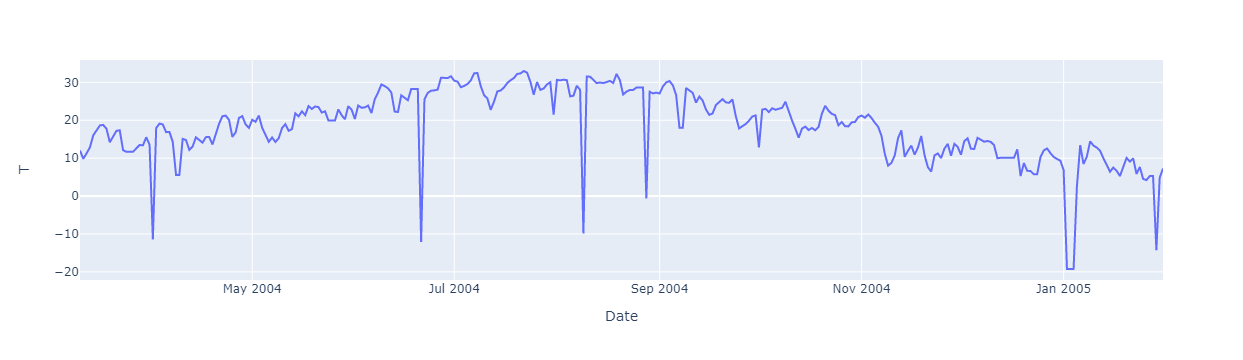

In [31]:
px.line(data_frame=df_basic_clean, y='T')

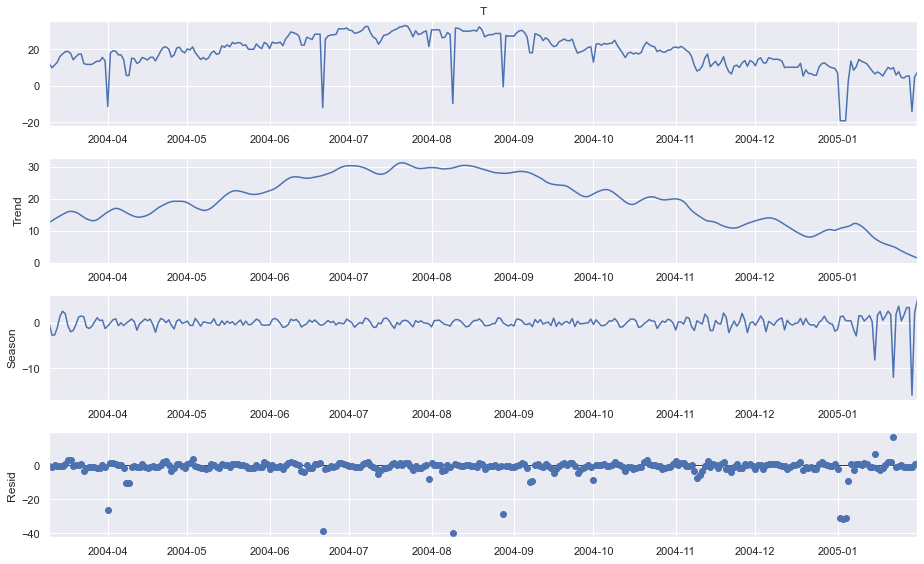

In [32]:
res = STL(df_basic_clean['T'], robust=True).fit()
res.plot()
plt.show()

- There is a upward non-linear trend in temperature from April to August, before the trend changes direction to become downwards. 
- The seasonality in the data does not appear to be very strong, and seems inconsistent.
- The temperature peaked between the months of June and September, where temperature was between 20 to 30 degrees celcius. The peak temperatures occured in July, where some days were above 30 degrees.
- The temperature is the lowest during the start of the year and near the end of the year, which are during the Winter season.
- The mean temperature does not remain constant through the year, but the variance appears to remain constant through the year.

##### Relative Humidity (RH)

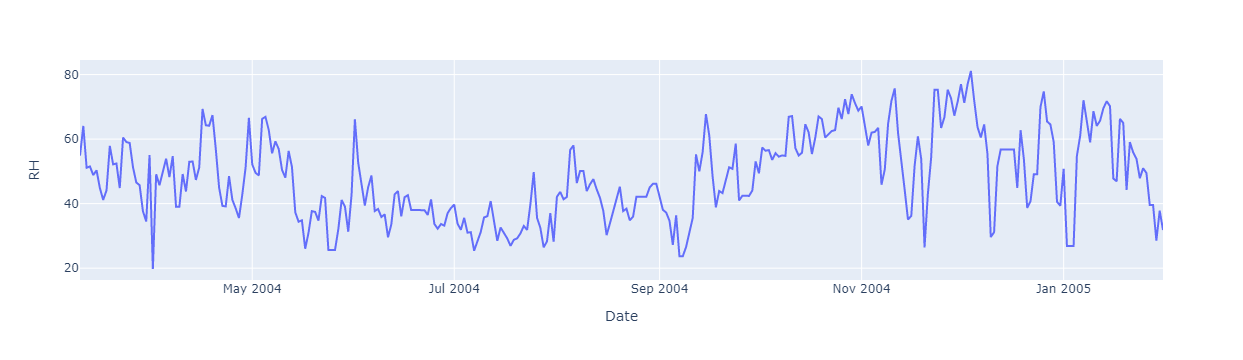

In [33]:
px.line(data_frame=df_basic_clean, y='RH')

We note that the variance of the relative humidity appears to increase when the relative humidity increases. This suggests a multiplicative decomposition of the data is appropriate. Since STL decomposition is only additive, we will use classical decomposition methods for this feature.

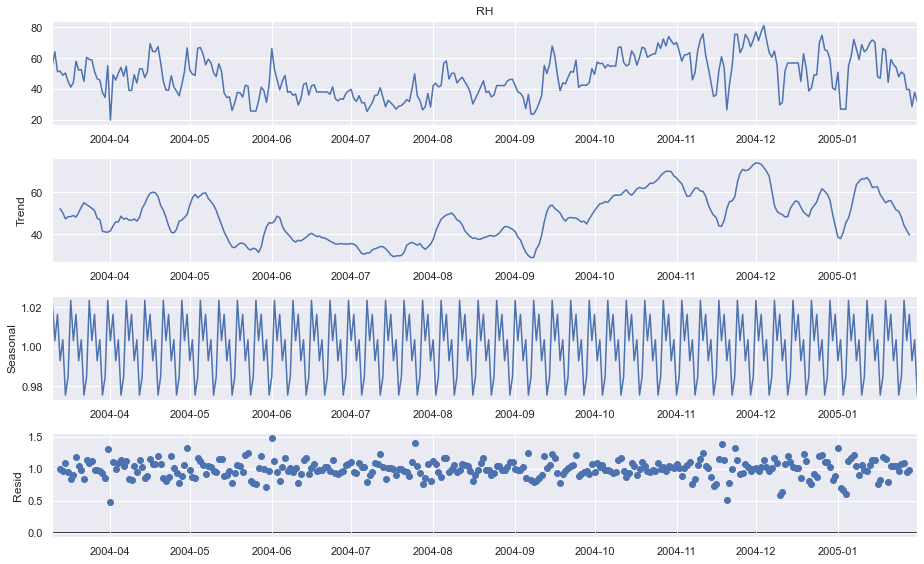

In [34]:
res = seasonal_decompose(df_basic_clean['RH'], 'multiplicative')
res.plot()
plt.show()

- There is a downward trend in relative humidity from April to August, before the trend changes direction to become downwards. The trend appears to be non-linear.
- It is clear that there is strong seasonality in the data, as even the trend appears to follow the seasonality after it is decomposed.
- The mean and variance of the relative humidity do not appear to be constant throughout the year, as the mean and variance of relative humidity appears to be lower during the months of June to September.
- This period of low humidity corresponds to a period of the highest temperatures of the year. This makes sense as **relative humidity is inversely proportional to temperature**
- Thus, the peak period of high relative humidity is also during the coldest parts of the year, during the end and the start of the year.

##### Carbon Monoxide (CO)

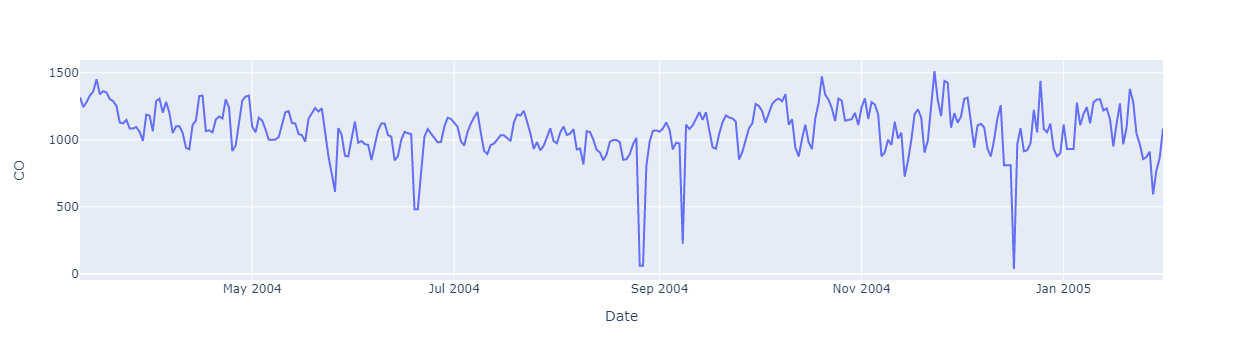

In [35]:
px.line(data_frame=df_basic_clean, y='CO')

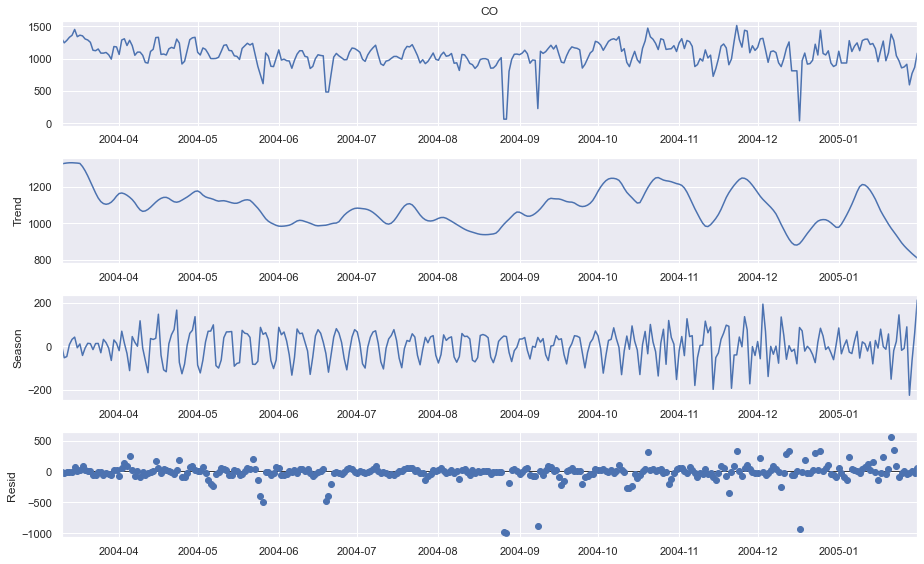

In [36]:
res = STL(df_basic_clean['CO'], robust=True).fit()
res.plot()
plt.show()

- The concentration of CO has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005 (but the trend becomes weaker nearing the end of the year)
- There is a seasonality in the data, that appears to repeat every week, where the concentration rises and falls. This could correspond to increased edmissions during the weekdays compared to weekends.
- The concentration of Carbon Monoxide appears to have a constant mean and variance, suggesting that it is stationary.
- On Weekends, it seems that CO concentration is lower, but this requires further statistical testing to verify. This could potentially be due to human sources of CO like vehicle emissions being lower when people are not working, and thus commuting less. 

##### Non-methane Hydrocarbons (NMHC)

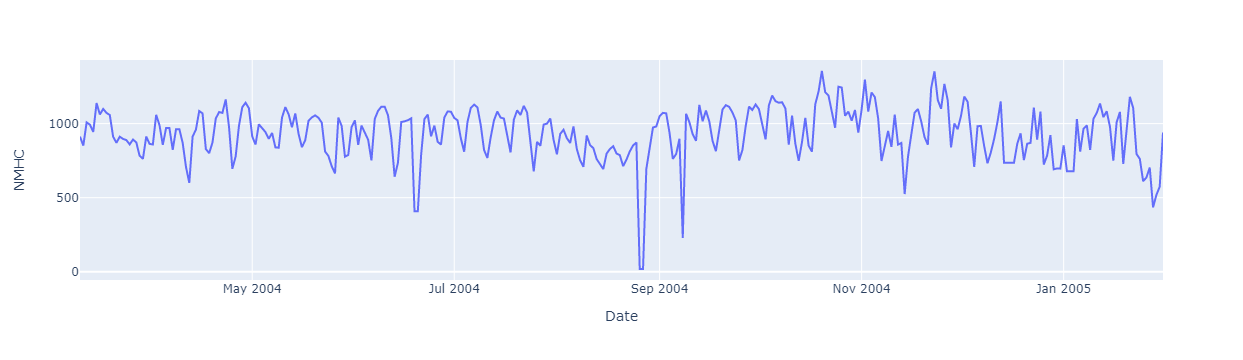

In [37]:
px.line(data_frame=df_basic_clean, y='NMHC')

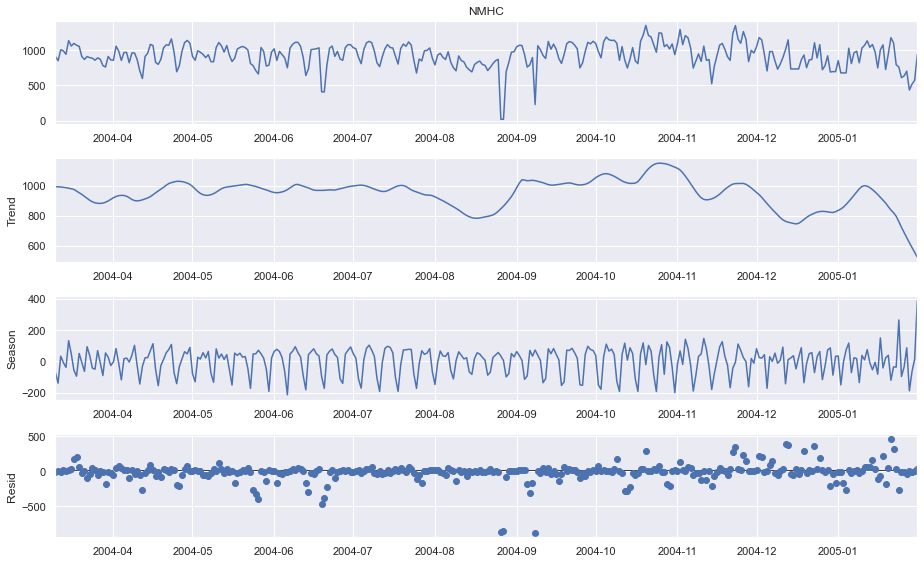

In [38]:
res = STL(df_basic_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- The trend for NMHC is very weak, and does not appear to change significantly
- The seasonality is much stronger, with there being a cycle that seemingly corresponds to each week.
- Similarily to that for CO, emissions of NMHC appear to be much lower during the weekends.
- One reason for this is that NMHC is also emitted via human sources like vehicle exhaust, chemical manufacturing and energy production, which might decrease during the weekend, when there is less human activity.

##### Nitrogen Oxides

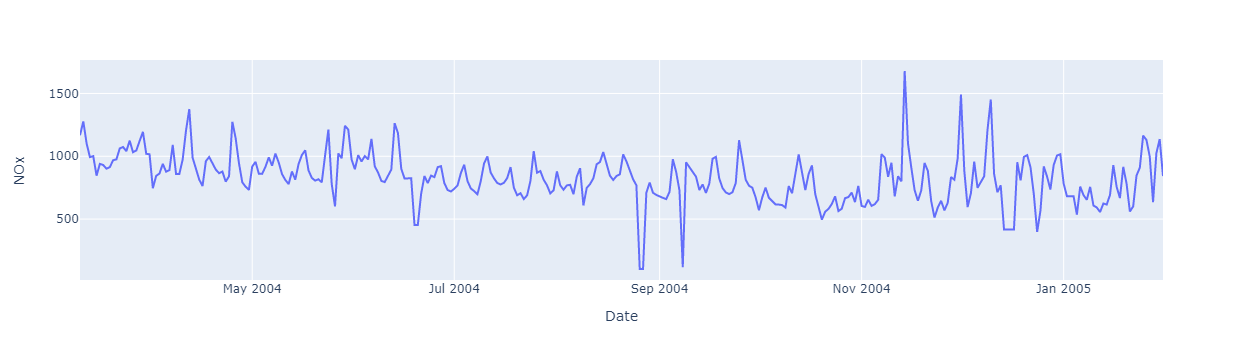

In [39]:
px.line(data_frame=df_basic_clean, y='NOx')

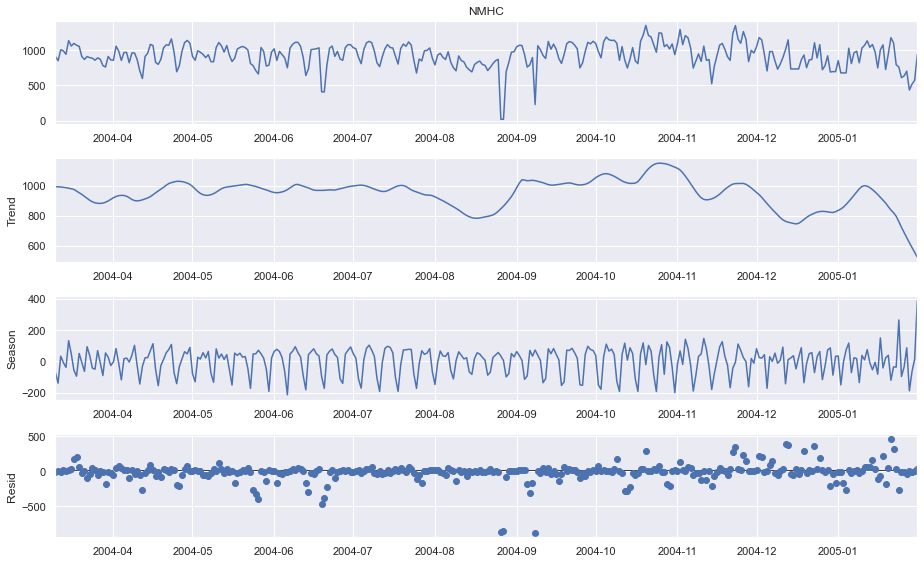

In [40]:
res = STL(df_basic_clean['NMHC'], robust=True).fit()
res.plot()
plt.show()

- For NOx concentrations, the time series does not appear to be stationary, as the mean and variance vary slightly
- There appears to be a small downward trend in the data
- There is a non-linear downward trend between April 2004 to November 2004, before changing directions to an upward trend from December 2004 to January 2001. This suggests that emissions of Nitrogen Oxides have been decreasing over time.
- This is corroborated by referencing the emission trend of Nitrogen oxides in Italy, where there has been a sharp decrease in NOx emissions fromm 2000 to 2018. [Source](https://www.statista.com/statistics/809161/nitrogen-oxides-nox-emission-trend-in-italy/)
- According to the European Environment Agency, this is due to the installation of catalysts to vehicles during this period as per new EU standards, resulting in lower NOx emissions from vehicles. (47% of the reduction in NOx emissions from 1990 and 2011 come from vehicle emissions)  [Source](https://www.eea.europa.eu/data-and-maps/indicators/eea-32-nitrogen-oxides-nox-emissions-1/assessment.2010-08-19.0140149032-3#:~:text=The%20sectors%20responsible%20for%20the,distribution%27%20(contributing%2027%25).)

##### Ozone (O3)

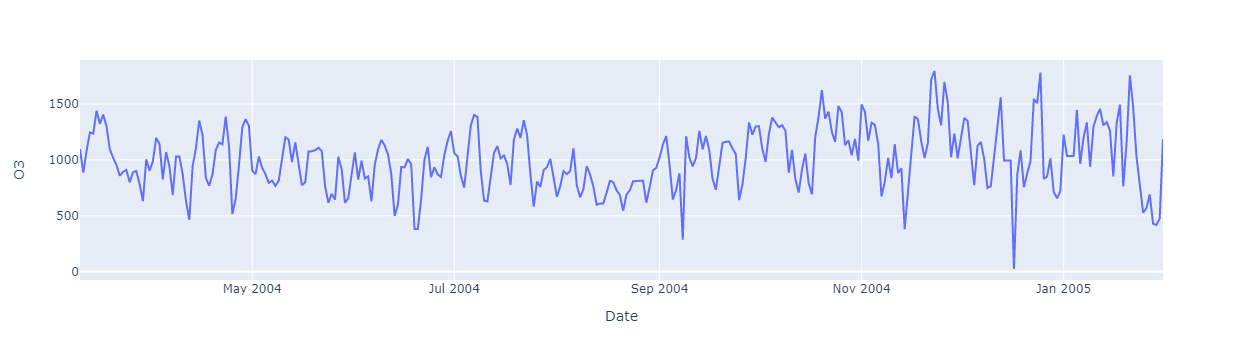

In [41]:
px.line(data_frame=df_basic_clean, y='O3')

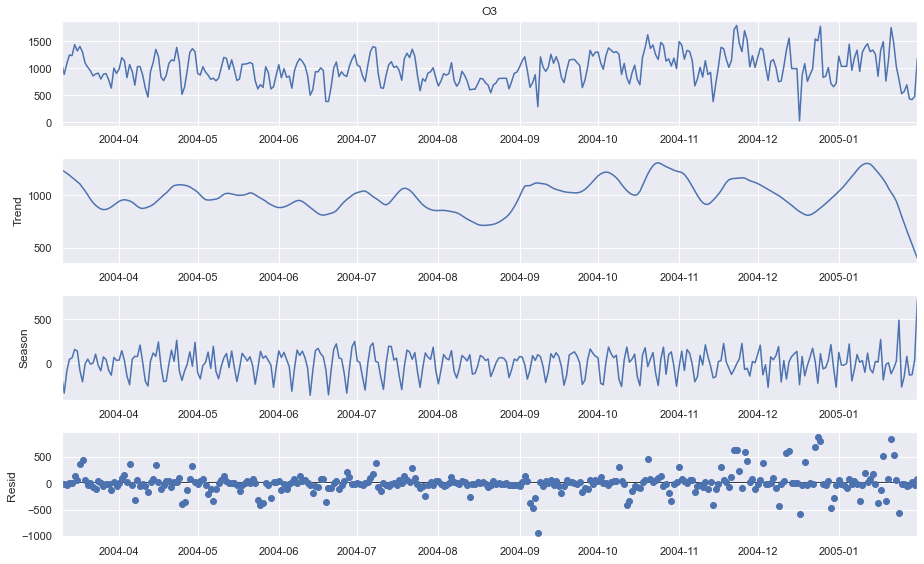

In [42]:
res = STL(df_basic_clean['O3'], robust=True).fit()
res.plot()
plt.show()

- The concentration of Ozone has a downward non-linear trend from April 2004 to August 2004, before changing direction to a upward trend from September 2004 to January 2005.
- The time series appears to have a constant mean, but there is some variation in the variance, such as during the start of the year.
- According to the US Environmental Protection Agency,ground level ozone, is not emitted directly into the air, but is created by chemical reactions between oxides of nitrogen (NOx) and volatile organic compounds (VOC). This happens when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight.
- This may explain why the highest levels of Ozone are also the periods of time in which NOx levels are the highest (November to January)
- Strangely, this period is also very cold, and low temperatures should cause levels of Ozone to become lower. Hence it is likely that the increase in Ozone is due to the higher levels of NOx

##### Strength of Trend and Seasonality
It is useful for us to know how strong trend and seasonality are in our time series data, for later model selection and improvement.

[For strongly trended data, the seasonally adjusted data should have much more variation than the remainder component.](https://otexts.com/fpp2/seasonal-strength.html) Therefore $Var(R_t)/Var(T_t+R_t)$ should be relatively small. But for data with little or no trend, the two variances should be approximately the same. So the strength of trend is defined as
$$
F_t = \max (0, 1 - \frac{Var(R_t)}{Var(T_t + R_t)})
$$

Similarily, we define the strength of seasonality as
$$
F_s = \max (0, 1 - \frac{Var(R_t)}{Var(S_t + R_t)})
$$

In [43]:
trends, seasonality, residuals = [], [], []
for feature in df_basic_clean.columns:
    decomposition = STL(df_basic_clean[feature], robust=True).fit()
    trends.append(decomposition.trend)
    seasonality.append(decomposition.seasonal)
    residuals.append(decomposition.resid)

decompose_df = pd.DataFrame({
    "Var_Trend" : [trend.var() for trend in trends],
    "Var_Seasonality + Residual" : [(season + resid).var() for season, resid in zip(seasonality, residuals)],
    "Var_Trend + Residual" : [(trend + resid).var() for trend, resid in zip(trends, residuals)],
    "Var_Residuals":  [resid.var() for resid in residuals],
}, index = df_basic_clean.columns)
decompose_df['Trend Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Trend + Residual'])), axis = 1)
decompose_df['Seasonal Strength'] = decompose_df.apply(lambda feature : max(0, 1 - (feature['Var_Residuals'] / feature['Var_Seasonality + Residual'])), axis = 1)

decompose_df

Var_Trend  Var_Seasonality + Residual  Var_Trend + Residual  \
Gas                                                                    
CO    10102.413936                23584.996228          35158.044584   
NMHC   9388.893215                23747.347272          26748.766489   
NOx   11085.555527                27198.962947          34876.283974   
O3    22094.398174                52172.255083          65342.591996   
T        56.985568                   27.794144             82.386004   
RH      118.949552                   66.441728            174.260273   

      Var_Residuals  Trend Strength  Seasonal Strength  
Gas                                                     
CO     21936.446830        0.376062           0.069898  
NMHC   18336.321271        0.314498           0.227858  
NOx    24251.980823        0.304628           0.108349  
O3     39294.674300        0.398636           0.246828  
T         27.205173        0.669784           0.021190  
RH        63.499944        0.635603           0.044276

- We see that out of all of the gases, Ozone has the strongest trend and Seasonality, whilst Carbon Monoxide has a strong trend but weak seasonality
- **No seasonal differencing** is recommended, as the strength of seasonality < 0.64 [Source: Forecasting Principles and Practices](https://otexts.com/fpp3/stationarity.html#unit-root-tests)

## Data Pre-processing
Now, we will proceed to process our data. This will involve transforming our data, and dealing with missing values and outliers.

In [193]:
def DataPreprocess(dataset, train = True, impute=True, remove_outliers=True, advanced_outlier_removal = False):
    missing_days = pd.isnull(dataset).any(axis=1)
    basic_outlier_rules = {
    "T" : (dataset['T'] < -20) | (dataset['T'] > 50),
    "RH" : (dataset['RH'] < 10) | (dataset['RH'] > 90)
}
    if remove_outliers:
        dataset.loc[basic_outlier_rules['T'], 'T'] = np.nan
        dataset.loc[basic_outlier_rules['RH'], 'RH'] = np.nan
        if train:
            additional_outlier_rules = {
            col : dataset[col] < 0 for col in ('CO', 'NMHC', 'NOx', 'O3')
    } 
            for col in dataset.columns:
                if advanced_outlier_removal:
                    outliers = mark_outliers(dataset, col, k=3, window=7)
                    is_outlier = outliers
                    dataset.loc[is_outlier, col] = np.nan
                    print("No of Outliers (Advanced Rules) for", col, np.sum(is_outlier))
                else:
                    if col in additional_outlier_rules:
                        is_outlier = additional_outlier_rules[col]
                        dataset.loc[is_outlier, col] = np.nan
                        print("No of Outliers (Basic Filtering) for", col, np.sum(is_outlier))
                        dataset.loc[is_outlier, col] = np.nan
    if impute:
        dataset = dataset.interpolate(method='time', limit_direction='forward')
    if not train:
        return dataset, missing_days
    else:
        return dataset

            


In [45]:
df_pivot.describe()

Gas             CO         NMHC          NOx           O3           T  \
count   322.000000   322.000000   322.000000   322.000000  322.000000   
mean   1074.034862   932.706457   831.478477   997.677396   15.578425   
std     192.346012   184.942814   200.428180   287.769529   23.412864   
min    -142.666667  -153.458333  -155.583333  -143.697917 -191.164583   
25%     981.338542   839.421875   712.370660   809.098958   12.627083   
50%    1084.482639   948.649306   826.208333  1005.692708   18.993750   
75%    1188.539062  1061.109375   944.387153  1183.658854   25.714149   
max    1513.208333  1355.104167  1678.687500  1795.291667   32.997917   

Gas            RH  
count  322.000000  
mean    44.343425  
std     28.487081  
min   -188.839583  
25%     37.101042  
50%     46.452083  
75%     58.028386  
max     81.104167

In [46]:
train = DataPreprocess(df_pivot, train=True, remove_outliers=True, impute=True)
train

No of Outliers (Basic Filtering) for CO 1
No of Outliers (Basic Filtering) for NMHC 2
No of Outliers (Basic Filtering) for NOx 2
No of Outliers (Basic Filtering) for O3 2


Gas                  CO         NMHC          NOx           O3          T  \
Date                                                                        
2004-03-10  1316.500000   912.250000  1167.250000  1096.041667  12.020833   
2004-03-11  1244.062500   851.802083  1277.187500   885.031250   9.833333   
2004-03-12  1281.562500  1008.229167  1101.718750  1084.218750  11.292708   
2004-03-13  1330.555556   992.822917   993.159722  1245.781250  12.866319   
2004-03-14  1360.927083   943.854167  1001.104167  1234.177083  16.016667   
...                 ...          ...          ...          ...        ...   
2005-01-27   911.777778   703.312500   997.059028   691.475694   5.267708   
2005-01-28   592.864583   434.350694   635.225694   429.375000  -4.502604   
2005-01-29   769.625000   518.093750  1024.666667   418.072917 -14.272917   
2005-01-30   864.642361   573.684028  1136.718750   474.392361   4.848611   
2005-01-31  1084.500000   939.791667   842.177083  1184.166667   7.273958   

Gas                RH  
Date                   
2004-03-10  54.883334  
2004-03-11  64.069791  
2004-03-12  51.107292  
2004-03-13  51.530903  
2004-03-14  48.843750  
...               ...  
2005-01-27  39.614930  
2005-01-28  34.089236  
2005-01-29  28.563542  
2005-01-30  37.832986  
2005-01-31  31.809375  

[328 rows x 6 columns]

## Modelling

### Evaluation Methodology
To evaluate our models, we will make use of:
- Corrected AIC
- Time Series Cross Validated Root Mean Square Error

### Utility Functions

In [47]:
gases = ['CO', 'NMHC', 'NOx', 'O3']

In [48]:
def adf_test(series, significance_level = 0.05):
    print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: There is a unit root (non-stationary time series)\nH1: There is no unit root (stationary time series)")
    test_statistic, pvalue, usedlag, *_ = adfuller(series)
    print(f"P-value: {pvalue:.3f}")
    print(f"Used Lag: {usedlag}")
    if pvalue < significance_level:
        print("Reject H0. There is evidence that the time series is stationary.")
    else:
        print("Fail to reject H0. There is insufficient evidence that the time series is stationary.")
    return test_statistic, pvalue, usedlag

In [49]:
def kpss_test(series, significance_level = 0.05):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        print(f"Test for Stationarity\nSignificance Level: {significance_level}\nH0: Process is trend stationary\nH1: There is a unit root (non-stationary)")
        test_statistic, pvalue, usedlag, *_ = kpss(series, regression="c", nlags="auto")
        print(f"P-value: {pvalue:.3f}")
        print(f"Used Lag: {usedlag}")
        if pvalue < significance_level:
            print("Reject H0. There is evidence that the time series is not stationary.")
        else:
            print("Fail to reject H0. There is insufficient evidence that the time series is not stationary.")
        return test_statistic, pvalue, usedlag

In [50]:
def multi_step_predict(model, existing_data, start, end, model_params = {}, test_exog = None):
    """
    Does multi-step time series prediction, where the model is refitted for every new prediction.
    """
    forecasts = []
    data = existing_data
    for date in pd.date_range(start, end):
        cur_model = model(data, **model_params).fit()
        try:
            if test_exog is not None:
                current_exog = test_exog.loc[:date]
                forecast = cur_model.predict(start=date, exog=current_exog).values[0]
            else:
                forecast = cur_model.predict(start=date).values[0]
        except:
            forecast = cur_model.get_prediction(start=date).predicted_mean.values[0]
        # forecast = cur_model.forecast(steps=1)
        forecasts.append(forecast)
        data.append(pd.Series(forecast))
    return forecasts, cur_model

In [51]:
def eval_model(model, dataset, model_params = {}, cv = TimeSeriesSplit(5), refit=False):
    """
    Function to evaluate a given model. It makes an assumption that the dataset that is passed to it is already pre-processed, or that the model will process it.
    It will return:
    - the model used
    - cross-validated metrics
    - final metrics 
    """
    if 'order' in model_params:
        order = model_params['order']
    else:
        order = (0, 0, 0)
    if 'exog' in model_params:
        exog = model_params['exog']
    # Cross validate
    cv_metrics = defaultdict(list)
    for train_idx, test_idx in cv.split(dataset):
        if 'exog' in model_params:
            train_exog = exog.iloc[train_idx]
            test_exog = exog.iloc[test_idx]
            model_params['exog'] = train_exog
        else:
            train_exog = None
            test_exog = None
        train_fold = dataset.iloc[train_idx]
        test_fold = dataset.iloc[test_idx]
        try:
            res = model(train_fold, **model_params).fit()
        except:
            res = model(train_fold,  initialization='approximate_diffuse',**model_params).fit()
        try:
            cv_metrics['Corrected AIC'].append(res.aicc)
        except Exception as Error:
            print(Error)
        try:
            if train_exog is not None:
                train_preds = res.predict(start=train_fold.index[0 + order[1]], end=train_fold.index[-1], exog=train_exog)
            else:
                train_preds= res.predict(start=train_fold.index[0 + order[1]], end=train_fold.index[-1])
        except:
            train_preds = res.get_prediction(start=train_fold.index[0 + order[1]], end=train_fold.index[-1], exog=train_exog).predicted_mean
        # train_preds = res.forecast(len(train_idx - order[1]))
        rmse_train = np.sqrt(mean_squared_error(train_fold[0 + order[1]:], train_preds))
        cv_metrics['Train RMSE'].append(rmse_train)
        if refit:
            test_preds, _ = multi_step_predict(model, train_fold, test_fold.index[0], test_fold.index[-1], model_params=model_params, test_exog=test_exog)
        else:
            if train_exog is not None:
                test_preds = res.predict(start=test_fold.index[0], end=test_fold.index[-1], exog=test_exog)
            else:
                test_preds = res.predict(start=test_fold.index[0], end=test_fold.index[-1])
        rmse_test = np.sqrt(mean_squared_error(test_fold, test_preds))
        cv_metrics['Test RMSE'].append(rmse_test)
        cv_metrics['Difference in RMSE'] =  rmse_train - rmse_test

    # Refit Model to Entire Training Set and Get Corrected AIC
    if 'exog' in model_params:
        model_params['exog'] = exog
    final_model = model(dataset, **model_params).fit()
    try:
        cv_metrics['Final AICc'] = [final_model.aicc] * cv.get_n_splits()
    except Exception as Error:
        print(Error)
    return final_model, cv_metrics

In [52]:
def parse_results(dataframe):
    cols = [pd.DataFrame(dataframe[col]) for col in dataframe.keys()]
    return pd.concat(cols, axis=1, keys=dataframe.keys())

In [53]:
def generate_file_name(text, extension = "pkl", location = "models", date = False):
    cur_date = pd.to_datetime("now")
    if date:
        return f"{location}/{text}_{cur_date.year}-{cur_date.month}-{cur_date.day}-{cur_date.hour}-{cur_date.minute}-{cur_date.second}.{extension}"
    else:
        return f"{location}/{text}.{extension}"

In [54]:
def record_history(model_name, cv_metrics, gas, past_history = None, save_history = True):
    if past_history is None:
        if save_history is True and path.exists("history.csv"):
            past_history = pd.read_csv("history.csv", index_col=0)
        else:
            past_history = pd.DataFrame(columns=['Model Name', 'Mean Test RMSE', 'Difference in RMSE', 'Final AICc', 'Gas'])
    cur_result = pd.Series({
        "Model Name" : model_name,
        "Mean Test RMSE" : np.mean(cv_metrics['Test RMSE']),
        'Difference in RMSE' : np.mean(cv_metrics['Difference in RMSE']),
        "Final AICc" : np.mean(cv_metrics['Final AICc']),
        "Gas" : gas
    })
    history = past_history.append(cur_result, ignore_index=True)
    if save_history:
        history.to_csv("history.csv")
    return history

In [55]:
def ts_plot(data, lags=31):
    gs = gridspec.GridSpec(2, 2)

    fig = plt.figure(figsize=(15, 8))
    time_plot = fig.add_subplot(gs[0, :])
    time_plot.plot(data)
    time_plot.set_title("Time Plot")
    acf_plot = fig.add_subplot(gs[1, 0])
    plot_acf(data, ax = acf_plot, lags=lags)
    pacf_plot = fig.add_subplot(gs[1, 1])
    plot_pacf(data, ax = pacf_plot, lags=lags)

    return fig

### Models

#### Exponential Smoothing

In [56]:
Exp_Smoothing_Results = defaultdict(list)
file_names = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning) # Silence warning about initialization of model in future versions
    for gas in tqdm(gases):
        final_model, cv_metrics = eval_model(ExponentialSmoothing, train[gas])
        Exp_Smoothing_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ExpSmoothingModel-{gas}", date=False, location="models/ExpSmoothing")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ExpSmoothingModel-{gas}", cv_metrics, gas)
results = parse_results(Exp_Smoothing_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.51it/s]


##### Model Analysis

In [57]:
results.T

count         mean           std          min  \
CO   Corrected AIC         5.0  1624.806310  8.710816e+02   544.802350   
     Train RMSE            5.0   125.912704  1.986140e+01   105.170521   
     Test RMSE             5.0   214.046608  6.174111e+01   153.326073   
     Difference in RMSE    5.0  -112.255036  1.588822e-14  -112.255036   
     Final AICc            5.0  3335.346233  0.000000e+00  3335.346233   
NMHC Corrected AIC         5.0  1650.076316  8.768561e+02   554.355223   
     Train RMSE            5.0   136.339552  1.741844e+01   114.198185   
     Test RMSE             5.0   184.115621  5.937760e+01   130.120761   
     Difference in RMSE    5.0   -18.115312  0.000000e+00   -18.115312   
     Final AICc            5.0  3315.245757  0.000000e+00  3315.245757   
NOx  Corrected AIC         5.0  1658.214051  8.759119e+02   568.887369   
     Train RMSE            5.0   141.611445  1.414760e+01   127.744422   
     Test RMSE             5.0   202.599322  5.871902e+01   123.412368   
     Difference in RMSE    5.0   -47.388969  0.000000e+00   -47.388969   
     Final AICc            5.0  3369.682556  0.000000e+00  3369.682556   
O3   Corrected AIC         5.0  1768.174673  9.145017e+02   622.693181   
     Train RMSE            5.0   202.141171  7.894115e+00   191.984586   
     Test RMSE             5.0   328.276812  6.653184e+01   221.262598   
     Difference in RMSE    5.0  -162.787982  0.000000e+00  -162.787982   
     Final AICc            5.0  3601.976835  5.084230e-13  3601.976835   

                                 25%          50%          75%          max  
CO   Corrected AIC       1080.485242  1562.486260  2197.787180  2738.470518  
     Train RMSE           109.233456   122.005826   146.270423   146.883294  
     Test RMSE            176.087097   183.174342   259.138330   298.507199  
     Difference in RMSE  -112.255036  -112.255036  -112.255036  -112.255036  
     Final AICc          3335.346233  3335.346233  3335.346233  3335.346233  
NMHC Corrected AIC       1100.880877  1610.567641  2215.629005  2768.948832  
     Train RMSE           126.255903   133.636140   152.323527   155.284003  
     Test RMSE            150.824682   173.399315   182.313027   283.920320  
     Difference in RMSE   -18.115312   -18.115312   -18.115312   -18.115312  
     Final AICc          3315.245757  3315.245757  3315.245757  3315.245757  
NOx  Corrected AIC       1112.863801  1614.458927  2202.163052  2792.697104  
     Train RMSE           129.439361   140.979703   147.732364   162.161375  
     Test RMSE            177.354443   209.550344   219.057805   283.621648  
     Difference in RMSE   -47.388969   -47.388969   -47.388969   -47.388969  
     Final AICc          3369.682556  3369.682556  3369.682556  3369.682556  
O3   Corrected AIC       1191.336314  1749.710257  2334.529776  2942.603838  
     Train RMSE           199.584110   200.124496   205.831058   213.181606  
     Test RMSE            310.788219   347.661349   375.969588   385.702306  
     Difference in RMSE  -162.787982  -162.787982  -162.787982  -162.787982  
     Final AICc          3601.976835  3601.976835  3601.976835  3601.976835

In [58]:
history

Model Name  Mean Test RMSE  Difference in RMSE   Final AICc  \
0    ExpSmoothingModel-CO      214.046608         -112.255036  3335.346233   
1  ExpSmoothingModel-NMHC      184.115621          -18.115312  3315.245757   
2   ExpSmoothingModel-NOx      202.599322          -47.388969  3369.682556   
3    ExpSmoothingModel-O3      328.276812         -162.787982  3601.976835   

    Gas  
0    CO  
1  NMHC  
2   NOx  
3    O3

- The Exponential Smoothing model for Ozone appears to perform the worse, with a cross-validated RMSE of 328

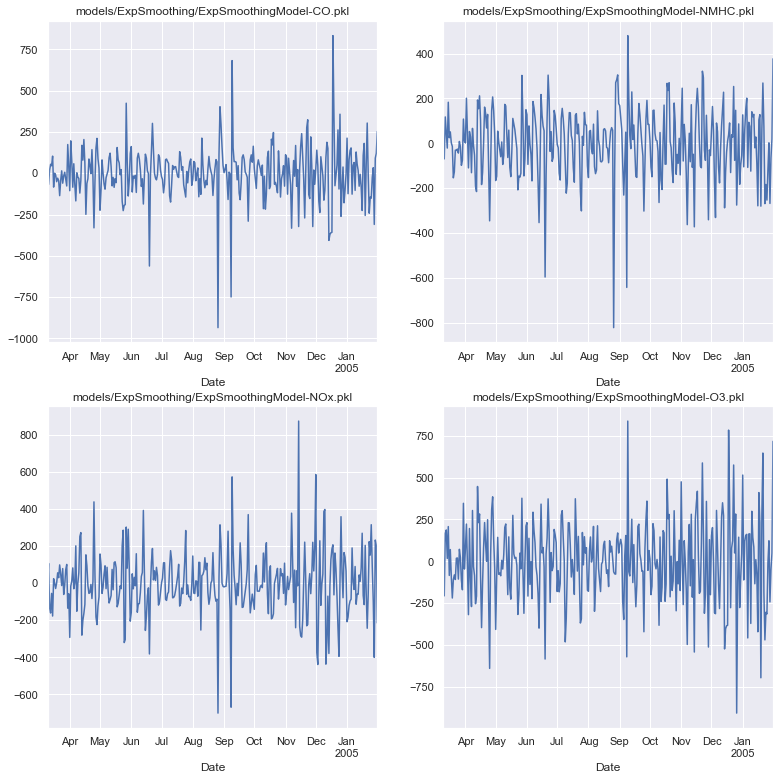

In [59]:
# Plot Residuals for Each Model
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
models = [(load(file), file) for file in file_names]
for model, subplot in zip(models, ax.ravel()):
    model[0].resid.plot(ax=subplot)
    subplot.set_title(model[1])

For the most part, the residuals appear to be homoskedastic.

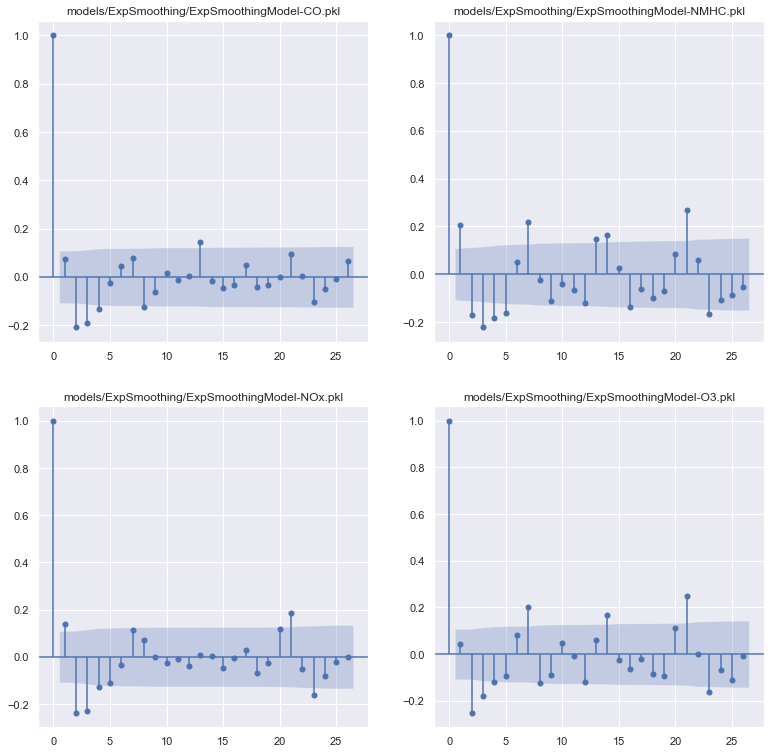

In [60]:
# Plot Autocorrelation of Residuals
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
for model, subplot in zip(models, ax.ravel()):
    plot_acf(model[0].resid, ax=subplot)
    subplot.set_title(model[1])

An ACF plot of the residuals suggests that our forecasts can be improved as the model still does not account for some information, which is left over in the residuals

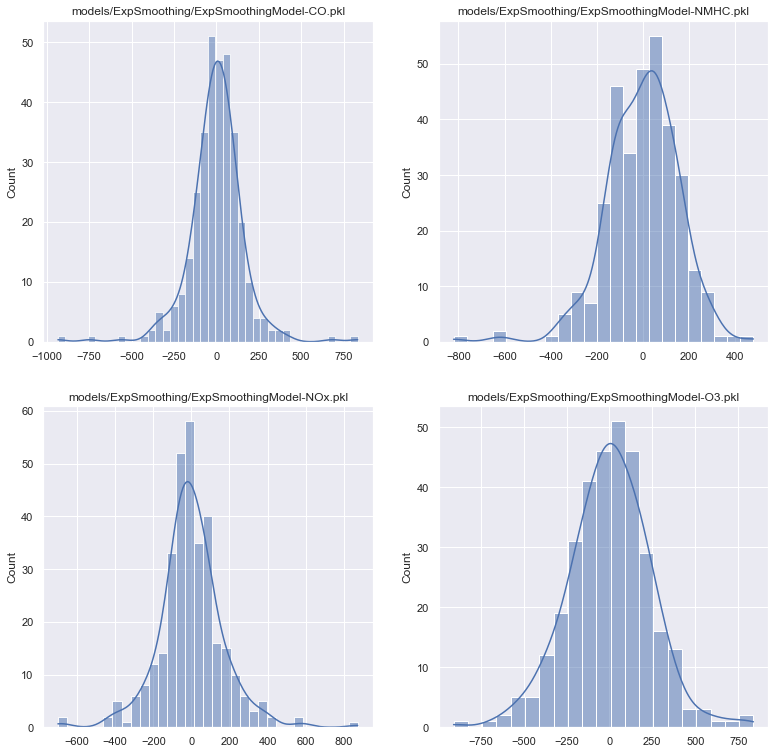

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(13, 13))
for model, subplot in zip(models, ax.ravel()):
    sns.histplot(model[0].resid, ax=subplot, kde=True)
    subplot.set_title(model[1])

The residuals appear to be normally distributed. While not essential, it is preferable for this to be the case.

#### ARIMA

##### Is the Data Stationary?

Before we can engage in modelling, we need to check if our data satisfies certain statistical assumptions that may be made by our models (ARIMA models). This will inform us if further pre-processing is needed. (e.g Differencing is required for our data).

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. 

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

[Source](https://otexts.com/fpp3/stationarity.html)

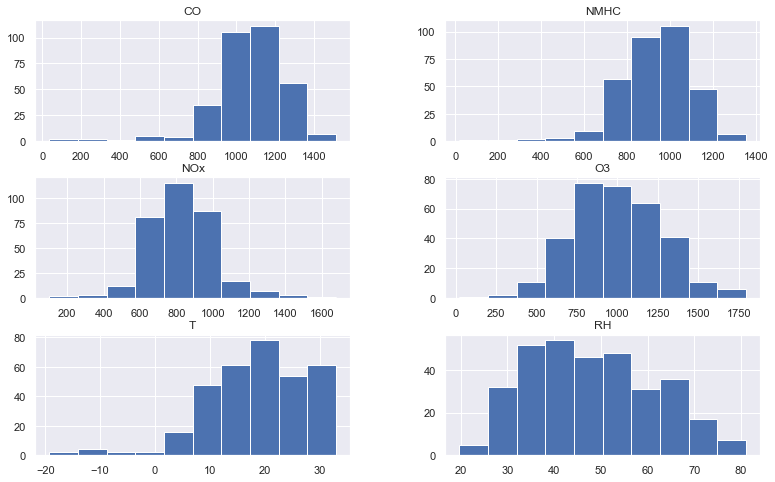

In [62]:
train.hist()
plt.show()

- On a first inspection, it appears that NOx is stationary. It is less clear if the rest are.

In [63]:
grp1 = train[:len(train) // 2]
grp2 = train[len(train) // 2:]

pd.concat([grp1.describe(), grp2.describe()], axis = 1, keys=["Grp1", "Grp2"]).T

count         mean         std         min         25%  \
     Gas                                                            
Grp1 CO    164.0  1071.233539  148.502711  481.753472  988.820313   
     NMHC  164.0   928.003525  131.248222  408.704861  845.799479   
     NOx   164.0   895.090024  147.592614  453.715278  796.906250   
     O3    164.0   938.729495  219.240231  382.131944  797.713542   
     T     164.0    21.844535    8.104707  -12.148958   16.668750   
     RH    164.0    42.783075   10.430817   19.742014   34.805469   
Grp2 CO    164.0  1070.028053  225.701653   36.281250  965.234375   
     NMHC  164.0   940.685086  201.612159   18.552083  819.289062   
     NOx   164.0   770.251524  203.675233  102.520833  644.192708   
     O3    164.0  1060.009527  316.176454   23.541667  829.388021   
     T     164.0    15.317867    8.511509  -19.247917   10.094531   
     RH    164.0    53.891071   13.337186   23.669792   43.834679   

                   50%          75%          max  
     Gas                                          
Grp1 CO    1059.015625  1158.091146  1452.010417  
     NMHC   930.397569  1034.760417  1163.041667  
     NOx    877.734375   975.135417  1376.031250  
     O3     931.322917  1087.466146  1439.041667  
     T       22.237847    28.783594    32.997917  
     RH      41.577952    49.856597    69.340625  
Grp2 CO    1110.880208  1205.656250  1513.208333  
     NMHC   963.611111  1084.477431  1355.104167  
     NOx    741.501736   884.520833  1678.687500  
     O3    1070.848958  1298.953993  1795.291667  
     T       14.696354    21.689323    30.365625  
     RH      54.857639    64.554427    81.104167

- The mean values for Grp 1 and 2 are similar for CO, NMHC, suggesting they are stationary

To tell more concretely if our data is stationary, we will conduct two tests, an Augmented Dickey Fuller Test, and a KPSS test.

###### ADF Test
ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

Null Hypothesis: The series has a unit root.

Alternate Hypothesis: The series has no unit root.

If the null hypothesis failed to be rejected, this test may provide evidence that the series is non-stationary.

[Reference: Statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html)


In [64]:
for gas in train[gases].columns:
    print(gas)
    adf_test(train[gas])

CO
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 1
Reject H0. There is evidence that the time series is stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.032
Used Lag: 12
Reject H0. There is evidence that the time series is stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 6
Reject H0. There is evidence that the time series is stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 8
Reject H0. There is evidence that the time series is stationary.


- According to the ADF test, all of the gas time series are stationary

###### KPSS Test
KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

We apply this test in addition to the ADF test, to ensure that our data is truly stationary.

In [65]:
for gas in train[gases].columns:
    print(gas)
    kpss_test(train[gas])

CO
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 8
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
NMHC
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 7
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
NOx
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 7
Reject H0. There is evidence that the time series is not stationary.
O3
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.038
Used Lag: 8
Reject H0. There is evidence that the time series is not stationary.


For O3 and NOx, we note that KPSS indicates the data is non-stationary, but the ADF test indicates it is stationary. The series is thus inferred to be difference stationary. 

We will difference the data, and check the differenced data for stationarity.

In [66]:
print("Results of KPSS Test on Differenced Series (O3)")
kpss_test(diff(train['O3']))

print("Results of ADF Test on Differenced Series (O3)")
adf_test(diff(train['O3']))

print("Results of KPSS Test on Differenced Series (NOx)")
kpss_test(diff(train['NOx']))


print("Results of ADF Test on Differenced Series (NOx)")
adf_test(diff(train['NOx']))

Results of KPSS Test on Differenced Series (O3)
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 41
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
Results of ADF Test on Differenced Series (O3)
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-stationary time series)
H1: There is no unit root (stationary time series)
P-value: 0.000
Used Lag: 11
Reject H0. There is evidence that the time series is stationary.
Results of KPSS Test on Differenced Series (NOx)
Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 100
Fail to reject H0. There is insufficient evidence that the time series is not stationary.
Results of ADF Test on Differenced Series (NOx)
Test for Stationarity
Significance Level: 0.05
H0: There is a unit root (non-station

(-13.035693629562433, 2.295821303360994e-24, 5)

We observe that after detrending via differencing, the KPSS test shows that O3 and NOx are now truly stationary.

##### Selecting the Order of the ARIMA Model

When using an ARIMA model, it is necessary to specify the order of the model -> p, d, q 

p = order of the Auto Regressive part of the model
d = degree of differencing
q = order of the Moving Average part

It is usually not possible to tell, simply from a time plot, what values of p and q are appropriate for the data. However, it is sometimes possible to use the ACF plot, and the closely related PACF plot, to determine appropriate values for p and q.

If the data are from an ARIMA(p, d,0) or ARIMA(0, d, q) model, then the ACF and PACF plots can be helpful in determining the value of p or q. If p and q are both positive, then the plots do not help in finding suitable values of p and q.

The data may follow an ARIMA(p, d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

- the ACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag p in the PACF, but none beyond lag p.

The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

- the PACF is exponentially decaying or sinusoidal;
- there is a significant spike at lag q in the ACF, but none beyond lag q.

[Source](https://otexts.com/fpp3/non-seasonal-arima.html)

Hence, we will use the ACF and PACF plot to estimate the models for each gas, to use as a baseline. We will then fit the identified model, and check that the model residuals are white noise.

###### Carbon Monoxide

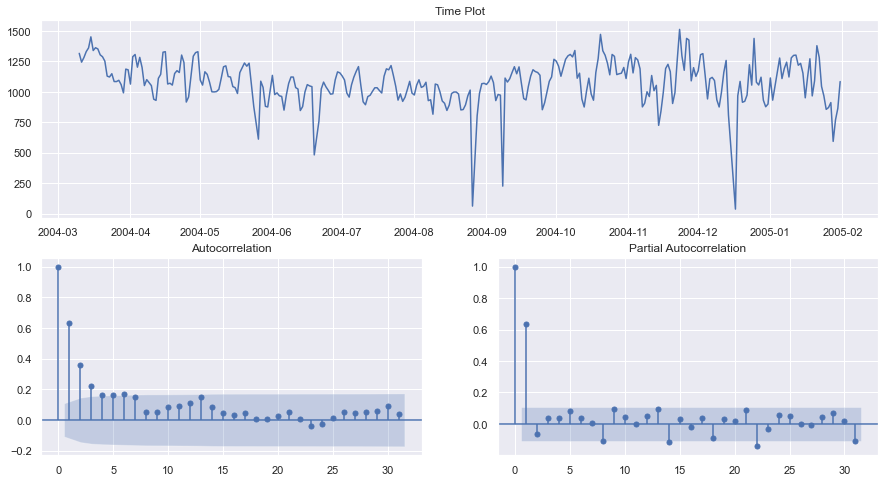

In [67]:
fig = ts_plot(train['CO'])

- Looking at the autocorrelation plot, it appear that the indicated model is an autoregressive model (as the ACF appears to be exponentially decaying)
- Looking then, at the PACF plot, there is a significant spike at lag 1, but none beyond that (there are some lags that are slightly above the confidence interval, but they do not appear to be significant)
- This suggests an ARIMA(1, 0, 0) model

###### Non Metanic Hydrocarbons

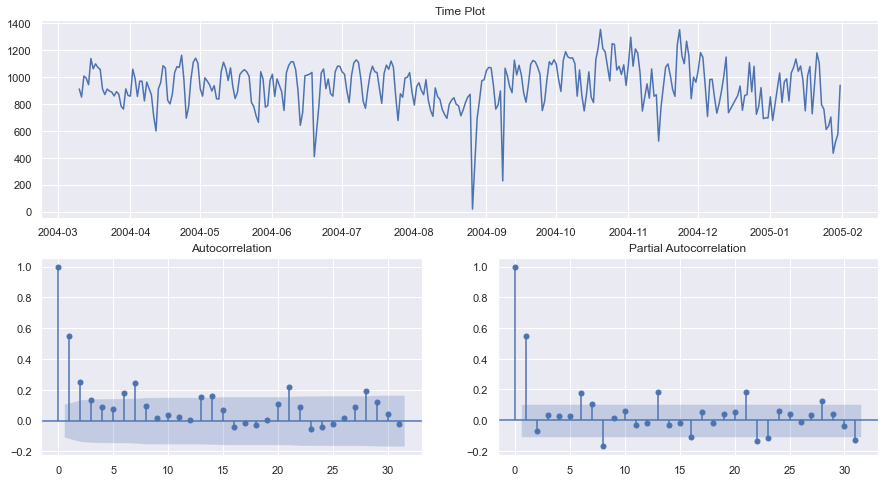

In [68]:
fig = ts_plot(train['NMHC'])

- Order identification is harder here
- Looking at the autocorrelation plot and the partial autocorrelation plot, both appear to tail off after lag 1. 
- This may indicate an ARMA(1,0,1) model

- Another view of the situation is that the ACF plot decays exponentially, while the PACF has a spike at lag one, suggesting an ARMA(1, 0, 0) model

###### Nitrogen Oxides

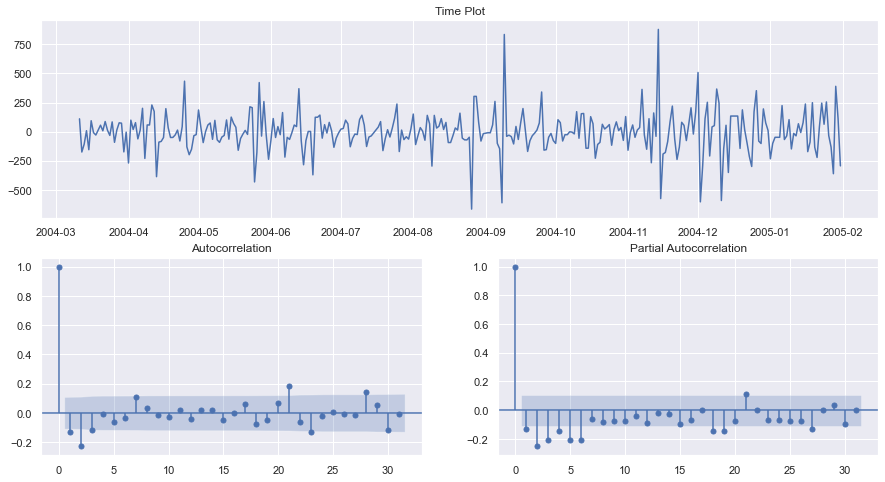

In [69]:
fig = ts_plot(diff(train['NOx']))

- Identification of the order is unclear here
- The autocrrelation plot shows that there are two spikes, with the rest very close to zero. The significant spike at lag 2, suggests a ARIMA(0, 1, 2) model

###### Ozone

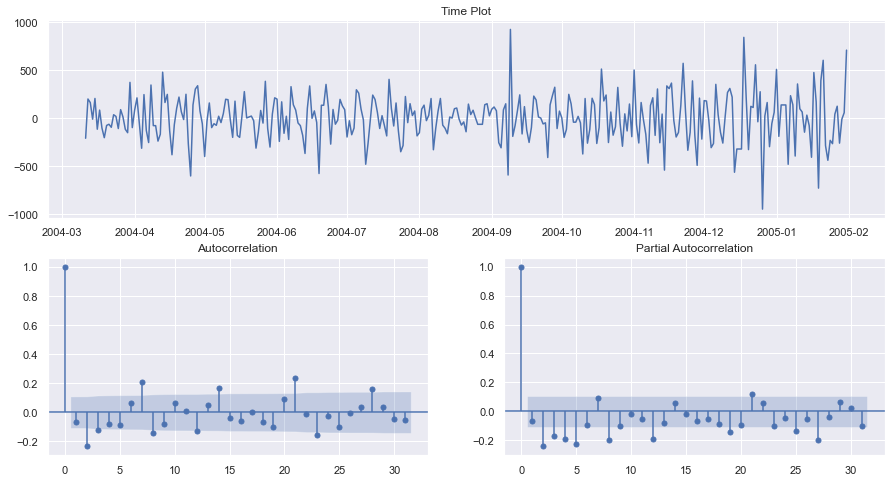

In [70]:
fig = ts_plot(diff(train['O3']))

- The ACF plot shows a few spikes, that occur at intervals of 7, suggesting a seasonal autoregressive term
- This suggests a ARIMA(0, 1, 2) model due to the spike at Lag 2 of the ACF plot

In [71]:
ARIMA_Results = defaultdict(list)
file_names = []
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (0, 1, 2),
    "O3" : (0, 1, 2)
}
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    for gas in tqdm(gases):
        order = orders[gas]
        final_model, cv_metrics = eval_model(ARIMA, train[gas], model_params = {'order' : order})
        ARIMA_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ARIMA-{order}-{gas}", date=False, location="models/ARIMA")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ARIMA-{order}-{gas}", cv_metrics, gas)
results = parse_results(ARIMA_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.65it/s]


##### Model Analysis

In [72]:
results.T

count         mean          std          min  \
CO   Corrected AIC         5.0  2073.390402  1099.713210   702.050691   
     Train RMSE            5.0   117.433400    17.946173    97.593868   
     Test RMSE             5.0   203.280773    48.675030   127.756060   
     Difference in RMSE    5.0  -118.969212     0.000000  -118.969212   
     Final AICc            5.0  4213.796890     0.000000  4213.796890   
NMHC Corrected AIC         5.0  2084.704711  1102.984127   705.477667   
     Train RMSE            5.0   120.918221    16.953202    99.944382   
     Test RMSE             5.0   176.621412    37.612632   127.728694   
     Difference in RMSE    5.0   -48.626404     0.000000   -48.626404   
     Final AICc            5.0  4188.591376     0.000000  4188.591376   
NOx  Corrected AIC         5.0  2084.490476  1101.580420   712.346246   
     Train RMSE            5.0   127.684876    13.103714   114.321887   
     Test RMSE             5.0   180.093999    47.741814   104.722975   
     Difference in RMSE    5.0   -60.548169     0.000000   -60.548169   
     Final AICc            5.0  4221.110015     0.000000  4221.110015   
O3   Corrected AIC         5.0  2194.991899  1144.809464   761.701117   
     Train RMSE            5.0   181.715428     9.110853   171.568604   
     Test RMSE             5.0   294.898746    76.441444   218.647840   
     Difference in RMSE    5.0  -202.790718     0.000000  -202.790718   
     Final AICc            5.0  4465.960399     0.000000  4465.960399   

                                 25%          50%          75%          max  
CO   Corrected AIC       1384.823703  2014.312908  2790.651926  3475.112783  
     Train RMSE           103.220049   114.499410   135.851326   136.002348  
     Test RMSE            186.580806   222.944685   224.150752   254.971560  
     Difference in RMSE  -118.969212  -118.969212  -118.969212  -118.969212  
     Final AICc          4213.796890  4213.796890  4213.796890  4213.796890  
NMHC Corrected AIC       1391.722903  2041.198476  2793.429789  3491.694721  
     Train RMSE           111.020343   117.359392   136.347751   139.919238  
     Test RMSE            147.986340   188.545642   200.640413   218.205971  
     Difference in RMSE   -48.626404   -48.626404   -48.626404   -48.626404  
     Final AICc          4188.591376  4188.591376  4188.591376  4188.591376  
NOx  Corrected AIC       1395.422307  2038.339576  2768.237656  3508.106593  
     Train RMSE           118.100592   126.097688   132.438380   147.465835  
     Test RMSE            160.489008   208.014005   210.143811   217.100195  
     Difference in RMSE   -60.548169   -60.548169   -60.548169   -60.548169  
     Final AICc          4221.110015  4221.110015  4221.110015  4221.110015  
O3   Corrected AIC       1470.703142  2172.310763  2906.866084  3663.378387  
     Train RMSE           177.130011   181.855174   181.885789   196.137560  
     Test RMSE            221.057075   307.362890   328.497646   398.928278  
     Difference in RMSE  -202.790718  -202.790718  -202.790718  -202.790718  
     Final AICc          4465.960399  4465.960399  4465.960399  4465.960399

In [73]:
history.sort_values("Mean Test RMSE")

Model Name  Mean Test RMSE  Difference in RMSE   Final AICc  \
5    ARIMA-(1, 0, 0)-NMHC      176.621412          -48.626404  4188.591376   
6     ARIMA-(0, 1, 2)-NOx      180.093999          -60.548169  4221.110015   
1  ExpSmoothingModel-NMHC      184.115621          -18.115312  3315.245757   
2   ExpSmoothingModel-NOx      202.599322          -47.388969  3369.682556   
4      ARIMA-(1, 0, 0)-CO      203.280773         -118.969212  4213.796890   
0    ExpSmoothingModel-CO      214.046608         -112.255036  3335.346233   
7      ARIMA-(0, 1, 2)-O3      294.898746         -202.790718  4465.960399   
3    ExpSmoothingModel-O3      328.276812         -162.787982  3601.976835   

    Gas  
5  NMHC  
6   NOx  
1  NMHC  
2   NOx  
4    CO  
0    CO  
7    O3  
3    O3

In terms of RMSE, the ARIMA models all outperform the Exponential Smoothing Models.

In [74]:
%%capture 
# ^suppress output
models = [load(file) for file in file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


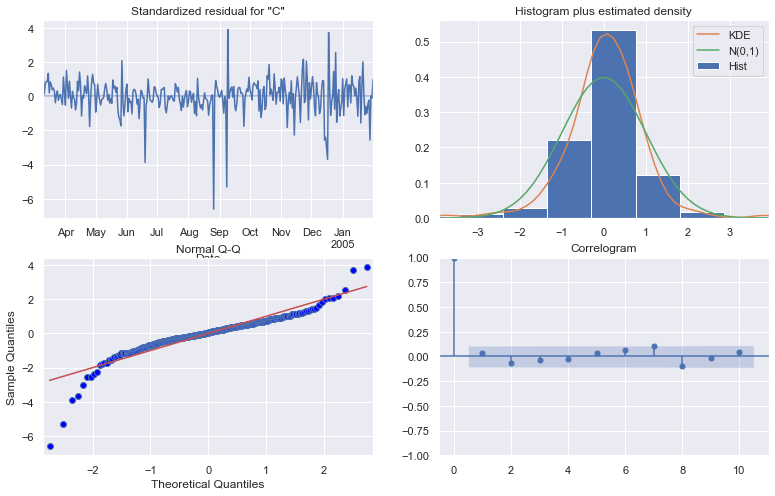

In [75]:
diagnostics[0]

- We observe from the Q-Q plot that the residuals are not normally distributed
- The correlogram does not show any significant correlation, except perhaps at Lag 7

In [76]:
models[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     CO   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2103.861
Date:                Thu, 12 Aug 2021   AIC                           4213.723
Time:                        00:00:06   BIC                           4225.102
Sample:                    03-10-2004   HQIC                          4218.263
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1070.6310     26.874     39.838      0.000    1017.958    1123.304
ar.L1          0.6317      0.025     25.173      0.000       0.582       0.681
sigma2      2.174e+04    807.941     26.909      0.000    2.02e+04    2.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              1316.51
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for CO are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.62, hence we would fail to reject the Null hypothesis of independently distributed residuals. Hence the residuals of this ARIMA model likely have no autocorrelation.

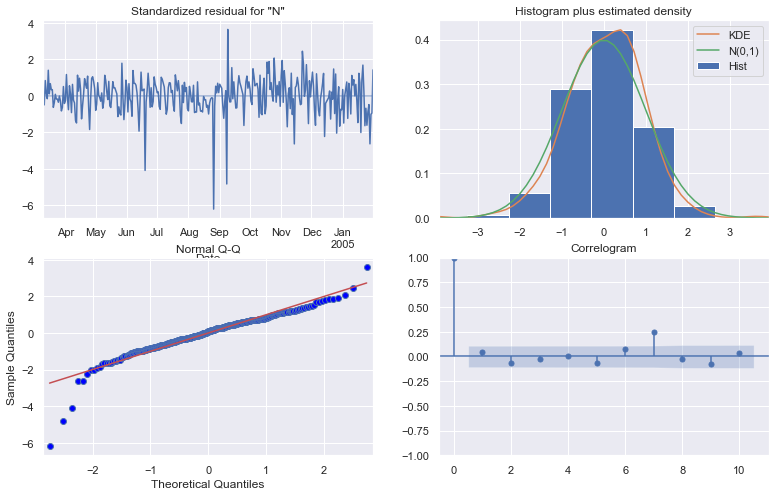

In [77]:
diagnostics[1]

- We observe that for NMHC:
    - Residuals are not normally distributed
    - There is significant correlation at Lag 7. This suggests that the ARIMA model fails to capture some sort of correlation that happens every week (i.e a seasonal pattern)

In [78]:
models[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   NMHC   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2091.259
Date:                Thu, 12 Aug 2021   AIC                           4188.517
Time:                        00:00:07   BIC                           4199.896
Sample:                    03-10-2004   HQIC                          4193.057
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        934.3443     19.717     47.388      0.000     895.700     972.988
ar.L1          0.5454      0.041     13.165      0.000       0.464       0.627
sigma2      2.024e+04    885.197     22.869      0.000    1.85e+04     2.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):               598.49
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                            -1.20
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for NMHC are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.23, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

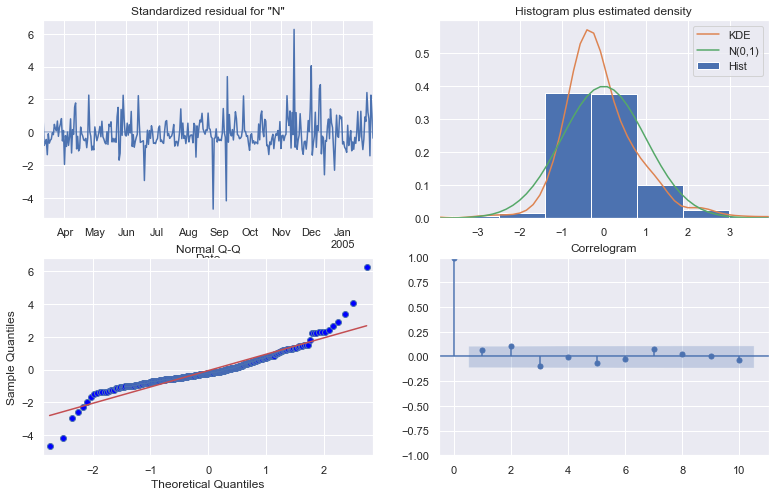

In [79]:
diagnostics[2]

- The residuals for NOx are certainly not normally distributed
- The correlogram does not show any significant correlation, except perhaps at Lag 2.

In [80]:
models[2].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NOx   No. Observations:                  328
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2107.518
Date:                Thu, 12 Aug 2021   AIC                           4221.036
Time:                        00:00:07   BIC                           4232.406
Sample:                    03-10-2004   HQIC                          4225.572
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4702      0.040    -11.683      0.000      -0.549      -0.391
ma.L2         -0.4614      0.047     -9.878      0.000      -0.553      -0.370
sigma2      2.309e+04    851.125     27.129      0.000    2.14e+04    2.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.53   Jarque-Bera (JB):               845.87
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             0.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for NOx are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.19, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

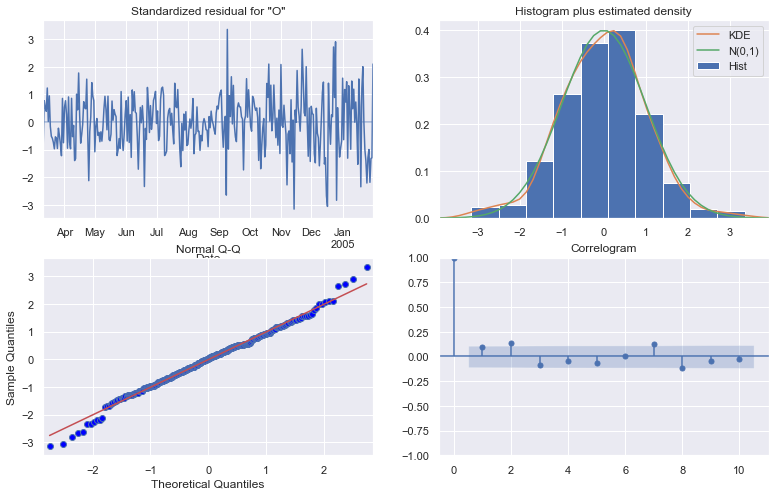

In [81]:
diagnostics[3]

- We observe that the residuals are mostly normally distributed
- There is one significant correlation at Lag 7, suggesting the ARIMA model does not account for seasonality that occurs on a weekly basis
- There is also a smaller correlation at Lag 2

In [82]:
models[3].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     O3   No. Observations:                  328
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2229.943
Date:                Thu, 12 Aug 2021   AIC                           4465.886
Time:                        00:00:08   BIC                           4477.256
Sample:                    03-10-2004   HQIC                          4470.423
                         - 01-31-2005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3562      0.043     -8.233      0.000      -0.441      -0.271
ma.L2         -0.4944      0.048    -10.399      0.000      -0.588      -0.401
sigma2      4.887e+04   3366.450     14.515      0.000    4.23e+04    5.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.86   Jarque-Bera (JB):                 5.74
Prob(Q):                              0.09   Prob(JB):                         0.06
Heteroskedasticity (H):               2.55   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- We observe that all the coefficients in the ARIMA model for O3 are significant.
- We note that the p-value obtained for the Ljung-Box test is 0.18, hence we would fail to reject the null hypothesis of no autocorrelation in the residuals if we had a significance level of 0.05.

#### SARIMA

##### Identifying Seasonal Orders

The seasonal part of the model consists of terms that are similar to the non-seasonal components of the model, but involve backshifts of the seasonal period.

The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an ARIMA(0,0,0)(0,0,1,12) model will show:

- a spike at lag 12 in the ACF but no other significant spikes;
- exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36, …).

Similarly, an ARIMA(0,0,0)(1,0,0,12) model will show:

- exponential decay in the seasonal lags of the ACF;
- a single significant spike at lag 12 in the PACF.
In considering the appropriate seasonal orders for a seasonal ARIMA model, restrict attention to the seasonal lags.

From our EDA, we discovered that we should not seasonally difference our data, as our data does not have strong seasonality ($F_s < 0.64$)

In [83]:
seasonal_lags = [i*7 for i in range(6)]

###### Carbon Monoxide

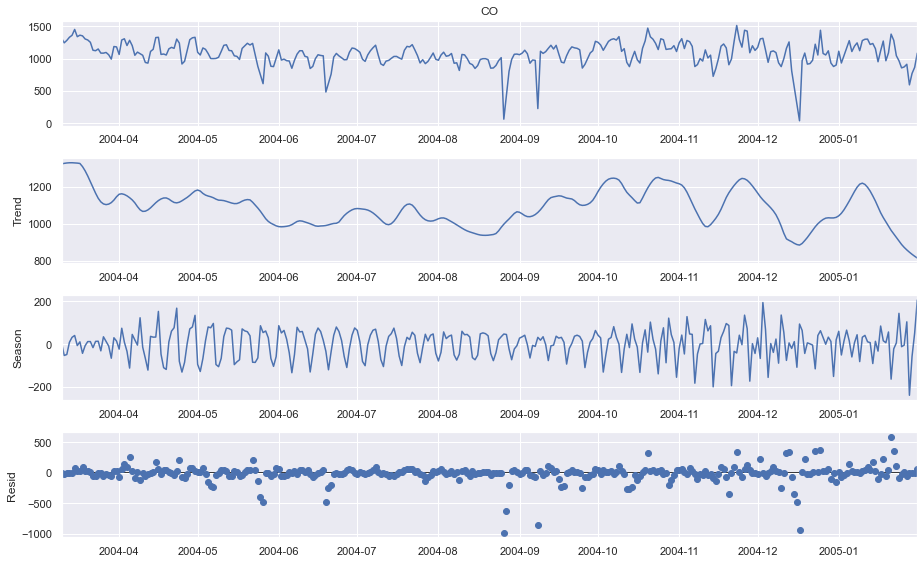

In [84]:
res = STL(train['CO'], robust=True).fit()
res.plot()
plt.show()

Looking at the decomposition of CO, there are four repeating seasons per month, suggesting m = 7.

In [85]:
decompose_df['Seasonal Strength']['CO']

0.06989822603268647

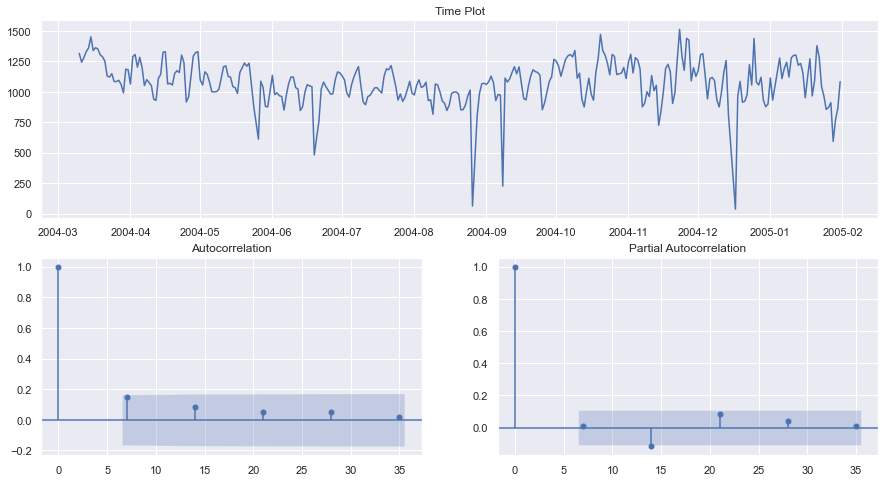

In [86]:
fig = ts_plot(train['CO'], seasonal_lags)

We observe that there do not appear to be any significant spikes at the seasonal lags. This suggests that we would be better served by an ARIMA model without any seasonality.

###### Non Metanic Hydrocarbons

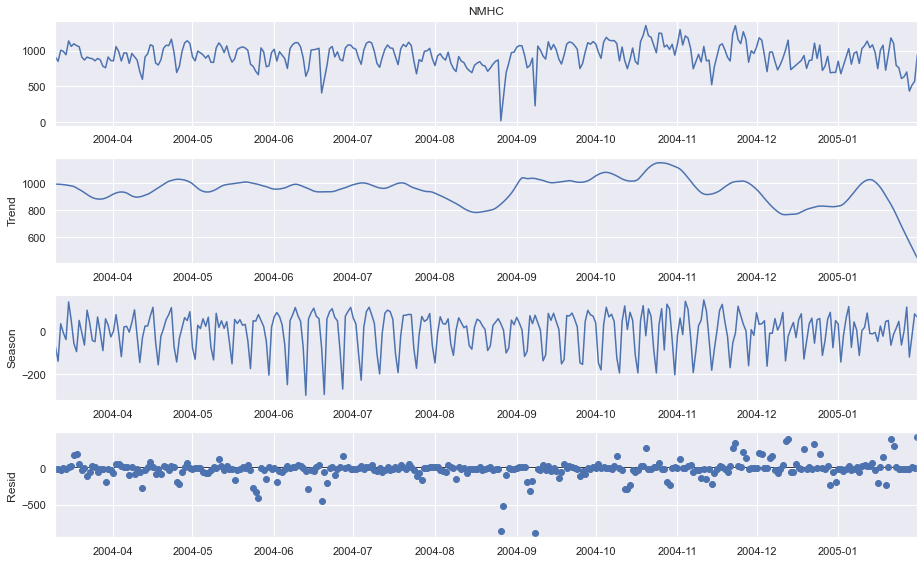

In [87]:
res = STL(train['NMHC'], robust=True).fit()
res.plot()
plt.show()

In [88]:
decompose_df['Seasonal Strength']['NMHC']

0.22785812404595274

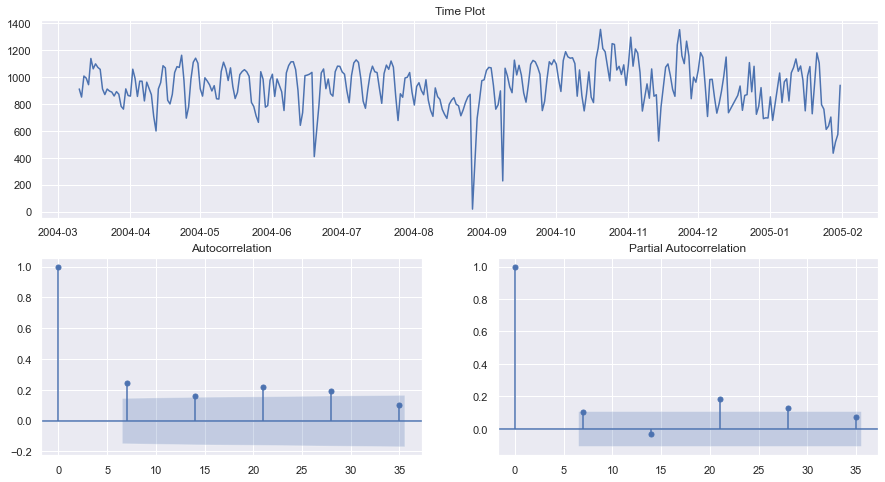

In [89]:
fig = ts_plot(train['NMHC'], seasonal_lags)

- This time series exhibits stronger seasonality. 
- We observe significant spikes in the PACF at Lag 21
- We observe significant spikes in the ACF at lag 7, 14 and 21

- To be more conservative, we will assume a SMA(3) order instead of a (3, 0, 3, 7) seasonal order

###### Nitrogen Oxides

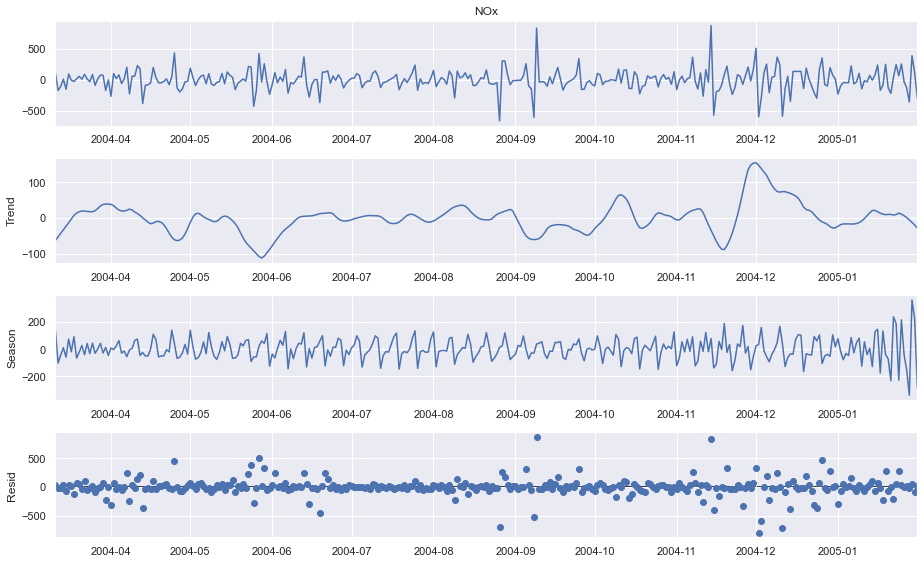

In [90]:
res = STL(diff(train['NOx']), robust=True).fit()
res.plot()
plt.show()

In [91]:
decompose_df['Seasonal Strength']['NOx']

0.10834906205123229

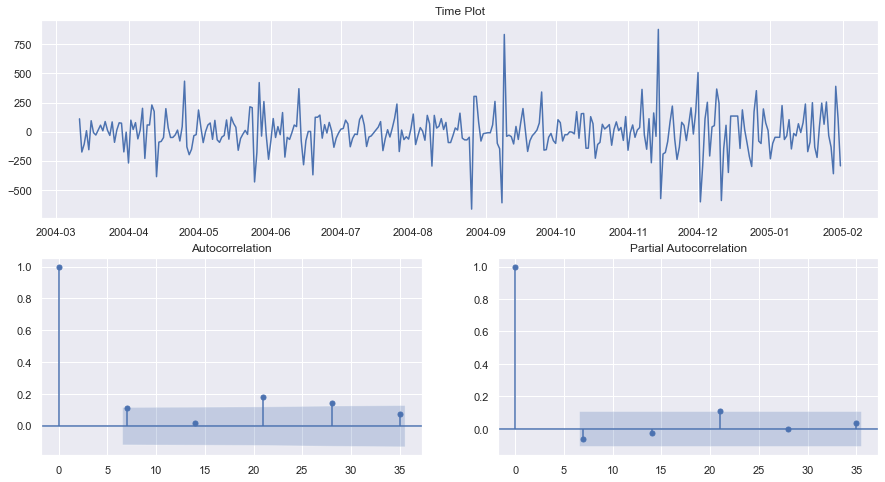

In [92]:
fig = ts_plot(diff(train['NOx'], 1), seasonal_lags)

- The PACF plot decays exponentially to zero
- The ACF plot shows significant seasonal spikes at seasonal lags at 21 and 28
- This might indicate a SMA(3) or SMA(4) model

###### Ozone

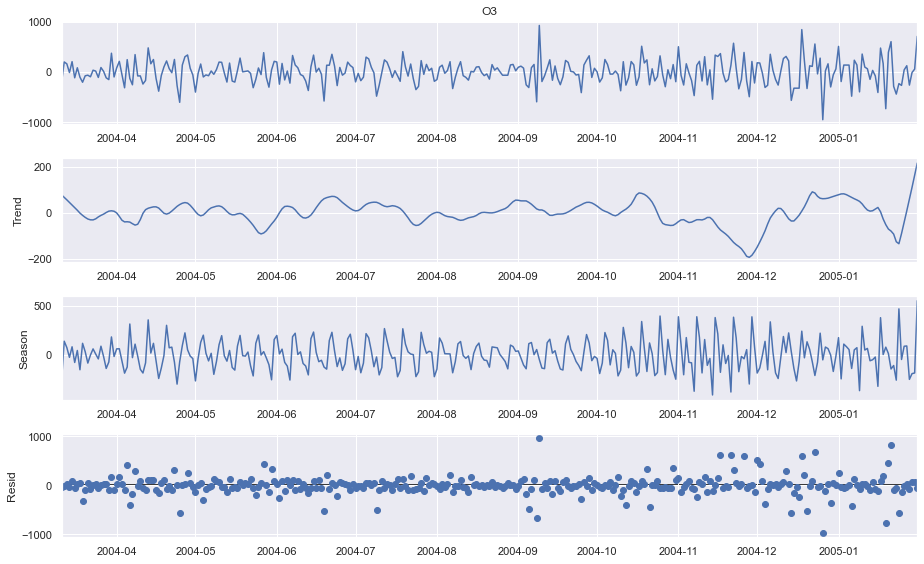

In [93]:
res = STL(diff(train['O3']), robust=True).fit()
res.plot()
plt.show()

In [94]:
decompose_df['Seasonal Strength']['O3']

0.24682814194582414

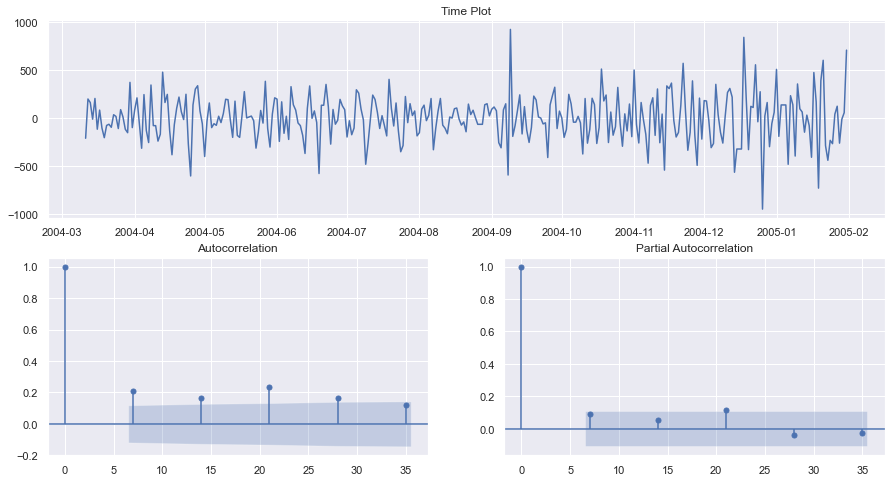

In [95]:
fig = ts_plot(diff(train['O3'], 1), seasonal_lags)

- From analysing the PACF plot, it suggests a SAR(4) model

In [96]:
seasonal_orders = {
    "NMHC" :  (0, 0, 3, 7),
    "NOx" :  (0, 0, 3, 7),
    "O3" :  (4, 0, 0, 7)
}
orders = {
    "CO" : (1, 0, 0),
    "NMHC" : (1, 0, 0),
    "NOx" : (0, 0, 2),
    "O3" : (0, 0, 2)
}
SARIMA_Results = defaultdict(list)
file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order} | ({'seasonal_order' : seasonal_order} if seasonal_order is not None else {}))
        SARIMA_Results[gas] = cv_metrics
        file_name = generate_file_name(f"SARIMA-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMA")
        file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"SARIMA-{order}-{seasonal_order}-{gas}", cv_metrics, gas)
results = parse_results(SARIMA_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.28s/it]


##### Model Analysis

In [98]:
results.T

count         mean           std          min  \
CO   Corrected AIC         5.0  2104.845661  1.117921e+03   714.555821   
     Train RMSE            5.0   173.739830  1.885033e+01   149.364671   
     Test RMSE             5.0   270.268912  1.261890e+02    93.021233   
     Difference in RMSE    5.0  -167.272746  0.000000e+00  -167.272746   
     Final AICc            5.0  4280.269100  0.000000e+00  4280.269100   
NMHC Corrected AIC         5.0  2108.022701  1.118139e+03   715.769161   
     Train RMSE            5.0   150.387208  1.270262e+01   129.428907   
     Test RMSE             5.0   489.107475  9.045413e+01   337.918327   
     Difference in RMSE    5.0  -349.124409  0.000000e+00  -349.124409   
     Final AICc            5.0  4244.135590  0.000000e+00  4244.135590   
NOx  Corrected AIC         5.0  2293.000935  1.171900e+03   807.104327   
     Train RMSE            5.0   252.455254  1.457235e+01   238.390008   
     Test RMSE             5.0   728.337558  3.600303e+01   696.044619   
     Difference in RMSE    5.0  -492.665252  6.355287e-14  -492.665252   
     Final AICc            5.0  4565.556459  0.000000e+00  4565.556459   
O3   Corrected AIC         5.0  2235.527609  1.121036e+03   809.973458   
     Train RMSE            5.0   265.313786  8.029142e+01   211.017808   
     Test RMSE             5.0   284.753751  1.097793e+02   166.147909   
     Difference in RMSE    5.0  -203.968888  0.000000e+00  -203.968888   
     Final AICc            5.0  4499.145417  0.000000e+00  4499.145417   

                                 25%          50%          75%          max  
CO   Corrected AIC       1403.369332  2038.580803  2836.679259  3531.043090  
     Train RMSE           169.343947   173.767703   174.061824   202.161006  
     Test RMSE            185.682430   336.616693   339.608446   396.415756  
     Difference in RMSE  -167.272746  -167.272746  -167.272746  -167.272746  
     Final AICc          4280.269100  4280.269100  4280.269100  4280.269100  
NMHC Corrected AIC       1407.395908  2043.262194  2840.583785  3533.102458  
     Train RMSE           147.711043   155.756091   158.221261   160.818739  
     Test RMSE            487.362356   507.345670   541.249451   571.661573  
     Difference in RMSE  -349.124409  -349.124409  -349.124409  -349.124409  
     Final AICc          4244.135590  4244.135590  4244.135590  4244.135590  
NOx  Corrected AIC       1544.642142  2316.682669  3023.060925  3773.514615  
     Train RMSE           240.210831   248.000846   265.763566   269.911018  
     Test RMSE            710.647722   713.804340   732.876082   788.315026  
     Difference in RMSE  -492.665252  -492.665252  -492.665252  -492.665252  
     Final AICc          4565.556459  4565.556459  4565.556459  4565.556459  
O3   Corrected AIC       1565.350898  2196.927487  2937.745192  3667.641012  
     Train RMSE           211.037962   214.202945   297.556072   392.754145  
     Test RMSE            182.342257   294.319961   365.951779   415.006849  
     Difference in RMSE  -203.968888  -203.968888  -203.968888  -203.968888  
     Final AICc          4499.145417  4499.145417  4499.145417  4499.145417

We note that the SARIMA CO model, with no seasonal order appears to overfit the data more than the ARIMA model for CO. We also observe that all the models appear to overfit our data heavily.

In [99]:
history.sort_values(["Gas", "Mean Test RMSE", "Difference in RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE  \
4                   ARIMA-(1, 0, 0)-CO      203.280773         -118.969212   
0                 ExpSmoothingModel-CO      214.046608         -112.255036   
8             SARIMA-(1, 0, 0)-None-CO      270.268912         -167.272746   
5                 ARIMA-(1, 0, 0)-NMHC      176.621412          -48.626404   
1               ExpSmoothingModel-NMHC      184.115621          -18.115312   
9   SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475         -349.124409   
6                  ARIMA-(0, 1, 2)-NOx      180.093999          -60.548169   
2                ExpSmoothingModel-NOx      202.599322          -47.388969   
10   SARIMA-(0, 0, 2)-(0, 0, 3, 7)-NOx      728.337558         -492.665252   
11    SARIMA-(0, 0, 2)-(4, 0, 0, 7)-O3      284.753751         -203.968888   
7                   ARIMA-(0, 1, 2)-O3      294.898746         -202.790718   
3                 ExpSmoothingModel-O3      328.276812         -162.787982   

     Final AICc   Gas  
4   4213.796890    CO  
0   3335.346233    CO  
8   4280.269100    CO  
5   4188.591376  NMHC  
1   3315.245757  NMHC  
9   4244.135590  NMHC  
6   4221.110015   NOx  
2   3369.682556   NOx  
10  4565.556459   NOx  
11  4499.145417    O3  
7   4465.960399    O3  
3   3601.976835    O3

### Model Improvement

#### Dynamic Regression Methods

An important consideration when estimating a regression with ARMA errors is that all of the variables in the model must first be stationary. If we estimate the model when any of these are non-stationary, the estimated coefficients will not be consistent estimates (and therefore may not be meaningful). One exception to this is the case where non-stationary variables are co-integrated. 
We therefore first difference the non-stationary variables in the model. It is often desirable to maintain the form of the relationship between  
$y_t$ and the predictors, and consequently it is common to difference all of the variables if any of them need differencing. The resulting model is then called a “model in differences,” as distinct from a “model in levels,” which is what is obtained when the original data are used without differencing.

In [100]:
kpss_test(train['T'])

Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


(1.1621169577361492, 0.01, 10)

In [101]:
kpss_test(train['RH'])

Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.010
Used Lag: 10
Reject H0. There is evidence that the time series is not stationary.


(0.9512603753066976, 0.01, 10)

Since both Temperature and Relative Humidity are not stationary, we need to difference them.

In [102]:
kpss_test(diff(train['T']))

Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 48
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


(0.26494853086482023, 0.1, 48)

In [103]:
kpss_test(diff(train['RH']))

Test for Stationarity
Significance Level: 0.05
H0: Process is trend stationary
H1: There is a unit root (non-stationary)
P-value: 0.100
Used Lag: 26
Fail to reject H0. There is insufficient evidence that the time series is not stationary.


(0.09133972124937181, 0.1, 26)

Since we need to difference all our variables, we will need to estimate new orders for CO and NMHC.

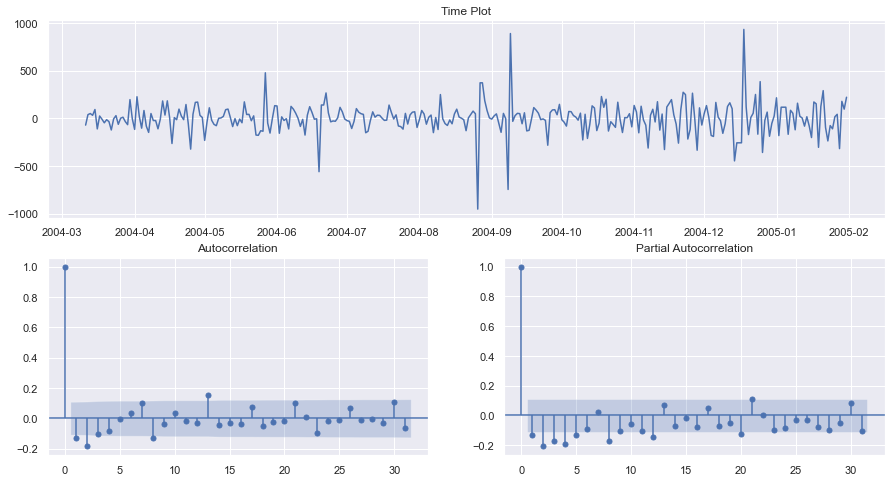

In [104]:
fig = ts_plot(diff(train['CO']))

The ACF plot suggests a MA(2) model.

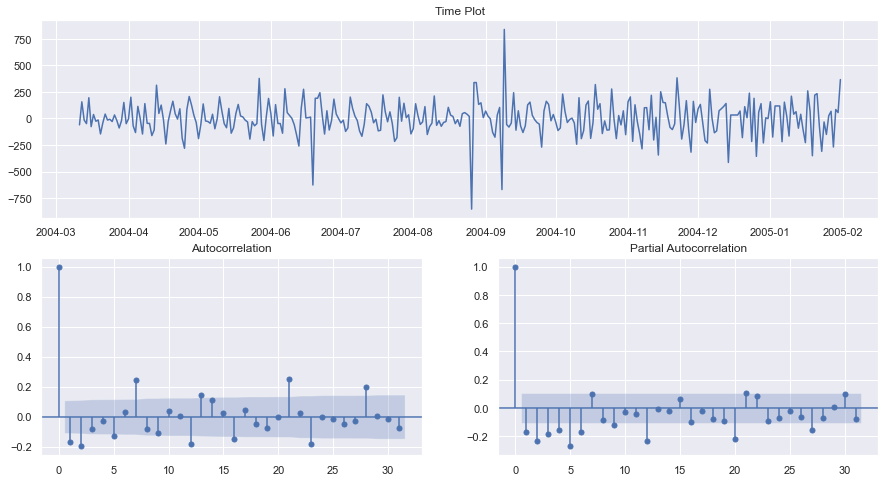

In [105]:
fig = ts_plot(diff(train['NMHC']))

The ACF plot suggests a MA(2) model, and SMA(2)

##### ARIMAX

In [106]:
orders = {
    "CO" : (0, 1, 2),
    "NMHC" : (0, 1, 2),
    "NOx" : (0, 1, 2),
    "O3" : (0, 1, 2)
}
ARIMAX_Results = defaultdict(list)
arimax_file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(ARIMA, train[gas], model_params = {'order' : order, 'exog' : exog})
        ARIMAX_Results[gas] = cv_metrics
        file_name = generate_file_name(f"ARIMAX-{order}-{gas}", date=False, location="models/ARIMAX")
        arimax_file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"ARIMAX-{order}-{gas}", cv_metrics, gas)
results = parse_results(ARIMAX_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.85it/s]


In [107]:
results.T

count         mean          std          min  \
CO   Corrected AIC         5.0  2035.262298  1086.324162   685.750691   
     Train RMSE            5.0   106.536254    17.778748    89.416450   
     Test RMSE             5.0   184.244569    68.091519    87.736435   
     Difference in RMSE    5.0  -113.127263     0.000000  -113.127263   
     Final AICc            5.0  4171.243789     0.000000  4171.243789   
NMHC Corrected AIC         5.0  2058.313342  1099.085507   690.394450   
     Train RMSE            5.0   113.804075    18.399191    93.458522   
     Test RMSE             5.0   178.563326    51.971933   133.297021   
     Difference in RMSE    5.0   -29.007113     0.000000   -29.007113   
     Final AICc            5.0  4157.286215     0.000000  4157.286215   
NOx  Corrected AIC         5.0  2084.635297  1101.125743   714.657407   
     Train RMSE            5.0   125.862201    13.926244   111.683016   
     Test RMSE             5.0   179.146555    48.204359   106.782501   
     Difference in RMSE    5.0   -53.560119     0.000000   -53.560119   
     Final AICc            5.0  4216.649664     0.000000  4216.649664   
O3   Corrected AIC         5.0  2190.069757  1140.227278   764.652599   
     Train RMSE            5.0   176.751168     9.770281   165.168579   
     Test RMSE             5.0   306.795922    77.340997   213.871412   
     Difference in RMSE    5.0  -181.051099     0.000000  -181.051099   
     Final AICc            5.0  4455.726114     0.000000  4455.726114   

                                 25%          50%          75%          max  
CO   Corrected AIC       1353.419619  1966.517215  2750.367834  3420.256129  
     Train RMSE            90.630230   102.184738   124.601370   125.848482  
     Test RMSE            156.827900   179.849080   237.728633   259.080796  
     Difference in RMSE  -113.127263  -113.127263  -113.127263  -113.127263  
     Final AICc          4171.243789  4171.243789  4171.243789  4171.243789  
NMHC Corrected AIC       1365.948483  2002.925177  2769.535001  3462.763597  
     Train RMSE           101.250843   108.102961   131.504494   134.703556  
     Test RMSE            147.533631   163.710669   182.798768   265.476539  
     Difference in RMSE   -29.007113   -29.007113   -29.007113   -29.007113  
     Final AICc          4157.286215  4157.286215  4157.286215  4157.286215  
NOx  Corrected AIC       1396.391893  2034.870874  2767.740828  3509.515481  
     Train RMSE           115.553128   124.196390   131.076593   146.801877  
     Test RMSE            155.119045   200.361995   206.611777   226.857457  
     Difference in RMSE   -53.560119   -53.560119   -53.560119   -53.560119  
     Final AICc          4216.649664  4216.649664  4216.649664  4216.649664  
O3   Corrected AIC       1468.029292  2164.256360  2899.149519  3654.261015  
     Train RMSE           171.470082   176.965051   178.706850   191.445279  
     Test RMSE            237.279126   328.119865   372.496378   382.212827  
     Difference in RMSE  -181.051099  -181.051099  -181.051099  -181.051099  
     Final AICc          4455.726114  4455.726114  4455.726114  4455.726114

In [108]:
history.sort_values(["Gas", "Mean Test RMSE", "Difference in RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE  \
12                 ARIMAX-(0, 1, 2)-CO      184.244569         -113.127263   
4                   ARIMA-(1, 0, 0)-CO      203.280773         -118.969212   
0                 ExpSmoothingModel-CO      214.046608         -112.255036   
8             SARIMA-(1, 0, 0)-None-CO      270.268912         -167.272746   
5                 ARIMA-(1, 0, 0)-NMHC      176.621412          -48.626404   
13               ARIMAX-(0, 1, 2)-NMHC      178.563326          -29.007113   
1               ExpSmoothingModel-NMHC      184.115621          -18.115312   
9   SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475         -349.124409   
14                ARIMAX-(0, 1, 2)-NOx      179.146555          -53.560119   
6                  ARIMA-(0, 1, 2)-NOx      180.093999          -60.548169   
2                ExpSmoothingModel-NOx      202.599322          -47.388969   
10   SARIMA-(0, 0, 2)-(0, 0, 3, 7)-NOx      728.337558         -492.665252   
11    SARIMA-(0, 0, 2)-(4, 0, 0, 7)-O3      284.753751         -203.968888   
7                   ARIMA-(0, 1, 2)-O3      294.898746         -202.790718   
15                 ARIMAX-(0, 1, 2)-O3      306.795922         -181.051099   
3                 ExpSmoothingModel-O3      328.276812         -162.787982   

     Final AICc   Gas  
12  4171.243789    CO  
4   4213.796890    CO  
0   3335.346233    CO  
8   4280.269100    CO  
5   4188.591376  NMHC  
13  4157.286215  NMHC  
1   3315.245757  NMHC  
9   4244.135590  NMHC  
14  4216.649664   NOx  
6   4221.110015   NOx  
2   3369.682556   NOx  
10  4565.556459   NOx  
11  4499.145417    O3  
7   4465.960399    O3  
15  4455.726114    O3  
3   3601.976835    O3

It appears that using regression with ARIMA creates models which are actually more robust, as they overfit less.

##### SARIMAX

In [109]:
seasonal_orders = {
    "NMHC" :  (0, 0, 3, 7),
    "NOx" :  (0, 0, 3, 7),
    "O3" :  (4, 0, 0, 7)
}
orders = {
    "CO" : (0, 1, 2),
    "NMHC" : (0, 1, 2),
    "NOx" : (0, 1, 2),
    "O3" : (0, 1, 2)
}
SARIMAX_Results = defaultdict(list)
sarimax_file_names = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gas in tqdm(gases):
        order = orders[gas]
        seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
        exog = train[['T', 'RH']]
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog})
        SARIMAX_Results[gas] = cv_metrics
        file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}", date=False, location="models/SARIMAX")
        sarimax_file_names.append(file_name)
        final_model.save(file_name)
        history = record_history(f"SARIMAX-{order}-{seasonal_order}-{gas}", cv_metrics, gas)
    results = parse_results(SARIMAX_Results).describe()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.71s/it]


In [110]:
results.T

count         mean           std          min  \
CO   Corrected AIC         5.0  2035.262298  1.086324e+03   685.750691   
     Train RMSE            5.0   106.536254  1.777875e+01    89.416450   
     Test RMSE             5.0   184.244569  6.809152e+01    87.736435   
     Difference in RMSE    5.0  -113.127263  0.000000e+00  -113.127263   
     Final AICc            5.0  4171.243789  0.000000e+00  4171.243789   
NMHC Corrected AIC         5.0  2041.780195  1.095166e+03   685.801470   
     Train RMSE            5.0   105.250142  2.081432e+01    83.858730   
     Test RMSE             5.0   181.499951  4.914089e+01   137.433211   
     Difference in RMSE    5.0   -34.893450  0.000000e+00   -34.893450   
     Final AICc            5.0  4141.853373  0.000000e+00  4141.853373   
NOx  Corrected AIC         5.0  2082.917456  1.102730e+03   709.109622   
     Train RMSE            5.0   120.989646  1.732676e+01   101.509561   
     Test RMSE             5.0   180.776511  5.121989e+01   100.800607   
     Difference in RMSE    5.0   -57.050072  7.944109e-15   -57.050072   
     Final AICc            5.0  4216.582451  0.000000e+00  4216.582451   
O3   Corrected AIC         5.0  2179.474367  1.127867e+03   770.523590   
     Train RMSE            5.0   166.911608  9.555759e+00   153.396372   
     Test RMSE             5.0   322.402112  1.089183e+02   198.054943   
     Difference in RMSE    5.0  -200.192557  0.000000e+00  -200.192557   
     Final AICc            5.0  4445.768697  0.000000e+00  4445.768697   

                                 25%          50%          75%          max  
CO   Corrected AIC       1353.419619  1966.517215  2750.367834  3420.256129  
     Train RMSE            90.630230   102.184738   124.601370   125.848482  
     Test RMSE            156.827900   179.849080   237.728633   259.080796  
     Difference in RMSE  -113.127263  -113.127263  -113.127263  -113.127263  
     Final AICc          4171.243789  4171.243789  4171.243789  4171.243789  
NMHC Corrected AIC       1351.999759  1969.070993  2759.082845  3442.945906  
     Train RMSE            89.602964    98.076812   126.430593   128.281612  
     Test RMSE            160.094395   163.175062   182.092076   264.705010  
     Difference in RMSE   -34.893450   -34.893450   -34.893450   -34.893450  
     Final AICc          4141.853373  4141.853373  4141.853373  4141.853373  
NOx  Corrected AIC       1397.610530  2029.802776  2769.243843  3508.820508  
     Train RMSE           107.842985   120.999235   129.662177   144.934273  
     Test RMSE            160.619999   201.984345   212.265091   228.212514  
     Difference in RMSE   -57.050072   -57.050072   -57.050072   -57.050072  
     Final AICc          4216.582451  4216.582451  4216.582451  4216.582451  
O3   Corrected AIC       1466.209548  2148.404481  2885.198652  3627.035562  
     Train RMSE           163.166171   168.092456   170.599195   179.303845  
     Test RMSE            240.693571   322.856609   379.496402   470.909036  
     Difference in RMSE  -200.192557  -200.192557  -200.192557  -200.192557  
     Final AICc          4445.768697  4445.768697  4445.768697  4445.768697

In [111]:
history.sort_values(["Gas", "Mean Test RMSE", "Difference in RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE  \
12                  ARIMAX-(0, 1, 2)-CO      184.244569         -113.127263   
16            SARIMAX-(0, 1, 2)-None-CO      184.244569         -113.127263   
4                    ARIMA-(1, 0, 0)-CO      203.280773         -118.969212   
0                  ExpSmoothingModel-CO      214.046608         -112.255036   
8              SARIMA-(1, 0, 0)-None-CO      270.268912         -167.272746   
5                  ARIMA-(1, 0, 0)-NMHC      176.621412          -48.626404   
13                ARIMAX-(0, 1, 2)-NMHC      178.563326          -29.007113   
17  SARIMAX-(0, 1, 2)-(0, 0, 3, 7)-NMHC      181.499951          -34.893450   
1                ExpSmoothingModel-NMHC      184.115621          -18.115312   
9    SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475         -349.124409   
14                 ARIMAX-(0, 1, 2)-NOx      179.146555          -53.560119   
6                   ARIMA-(0, 1, 2)-NOx      180.093999          -60.548169   
18   SARIMAX-(0, 1, 2)-(0, 0, 3, 7)-NOx      180.776511          -57.050072   
2                 ExpSmoothingModel-NOx      202.599322          -47.388969   
10    SARIMA-(0, 0, 2)-(0, 0, 3, 7)-NOx      728.337558         -492.665252   
11     SARIMA-(0, 0, 2)-(4, 0, 0, 7)-O3      284.753751         -203.968888   
7                    ARIMA-(0, 1, 2)-O3      294.898746         -202.790718   
15                  ARIMAX-(0, 1, 2)-O3      306.795922         -181.051099   
19    SARIMAX-(0, 1, 2)-(4, 0, 0, 7)-O3      322.402112         -200.192557   
3                  ExpSmoothingModel-O3      328.276812         -162.787982   

     Final AICc   Gas  
12  4171.243789    CO  
16  4171.243789    CO  
4   4213.796890    CO  
0   3335.346233    CO  
8   4280.269100    CO  
5   4188.591376  NMHC  
13  4157.286215  NMHC  
17  4141.853373  NMHC  
1   3315.245757  NMHC  
9   4244.135590  NMHC  
14  4216.649664   NOx  
6   4221.110015   NOx  
18  4216.582451   NOx  
2   3369.682556   NOx  
10  4565.556459   NOx  
11  4499.145417    O3  
7   4465.960399    O3  
15  4455.726114    O3  
19  4445.768697    O3  
3   3601.976835    O3

In [112]:
%%capture 
# ^suppress output
models = [load(file) for file in sarimax_file_names]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    diagnostics = [model.plot_diagnostics() for model in models]


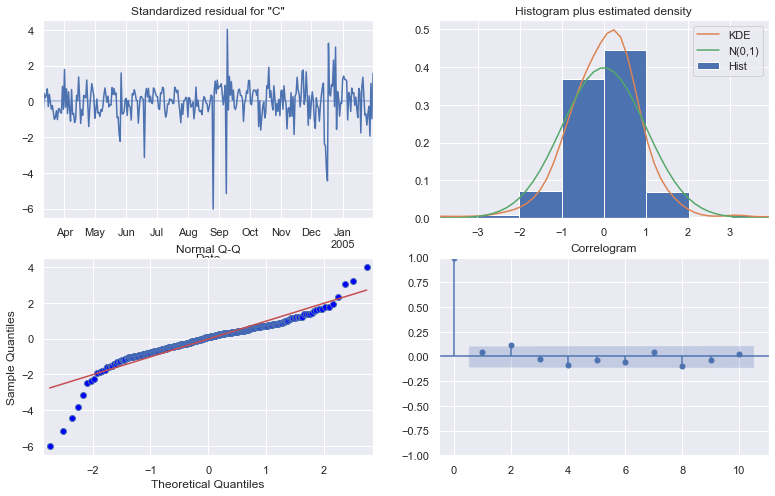

In [113]:
diagnostics[0]

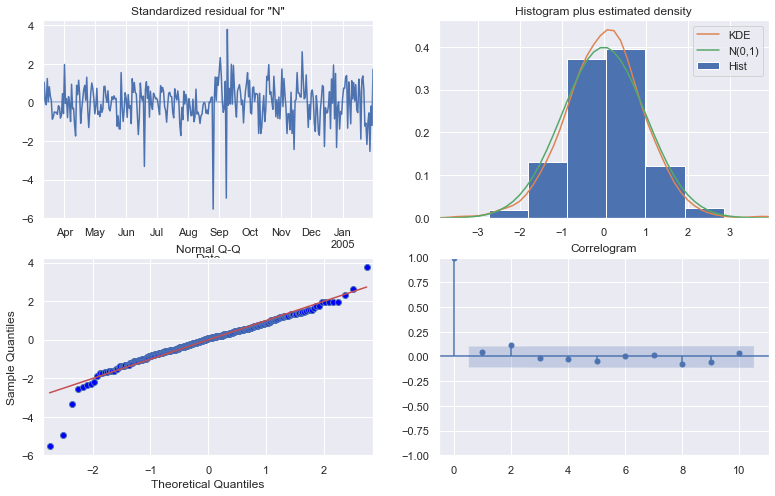

In [114]:
diagnostics[1]

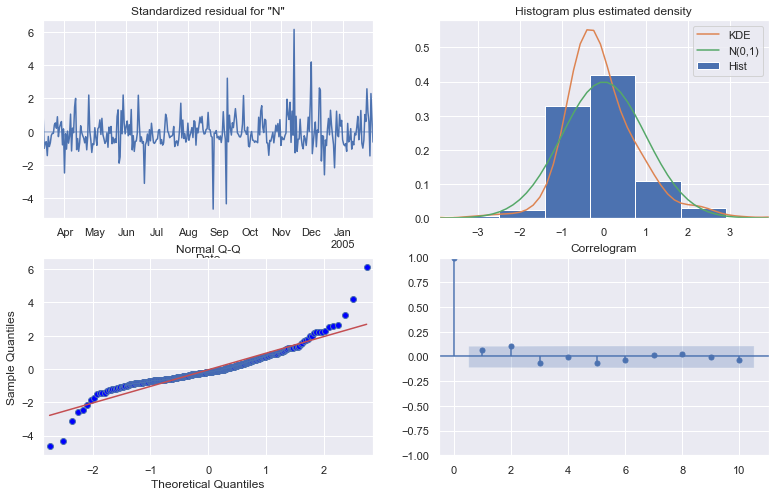

In [115]:
diagnostics[2]

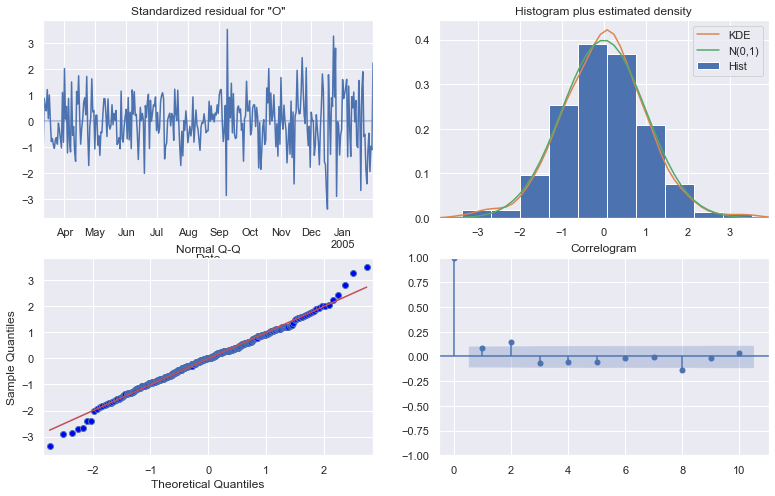

In [116]:
diagnostics[3]

#### Hyperparameter Tuning

##### Best Order

##### CO

In [249]:
def get_param_grid(data, gas,param_grid):
    data = data[gas]
    # Select order of differencing
    ## Try seasonal differencing
#     d = param_grid['d']
#     if 'D' in param_grid:
#         D = param_grid['D']
#     if 'D' in param_grid:
#         for i in param_grid['D']:
#             kpss_result = kpss(diff(data, i))
#             if kpss_result[0] >= 0.05: # if seasonal difference is stationary
#                 D = i
#                 break
          
#     ## Try first difference
#     for i in param_grid['d']:
#         kpss_result = kpss(diff(data, i + D))
#         if kpss_result[0] >= 0.05:
#             d = i
#             break

    orders = [
        (p, d, q) for p in param_grid['p'] for q in param_grid['q'] for d in param_grid['d']
    ]

    if 'P' in param_grid and 'Q' in param_grid and 'm' in param_grid:
        seasonal_orders = [
        (P, D, Q, m) for P in param_grid['P'] for Q in param_grid['Q'] for m in param_grid['m'] for D in param_grid['D']
    ]
    else:
        seasonal_orders = [None]

    if 'trend' in param_grid:
       trends = param_grid['trend']
    else:
        trends = ['n'] 
    
    exogs = param_grid['exog']
    return [              {
                        'order' : order,
                        'seasonal_order' : seasonal_order,
                        'trend' : trend,
                        'exog' : exog
                    } for order in orders for seasonal_order in seasonal_orders for trend in trends for exog in exogs
]

In [141]:
def score_aic(data, param, model):
    try:
        cur_model = model(data, **param).fit()
        # cur_model.save(name)
        aicc = cur_model.aicc
    except:
        aicc = np.inf
    return aicc 

In [245]:
def score_cv(data, param, model):
    try:
        cur_model, cv_metrics = eval_model(model, data, model_params=param, refit=False)
        # cur_model.save(name)
    except:
        return np.inf, np.inf
    return np.mean(cv_metrics['Test RMSE']), np.mean(cv_metrics['Difference in RMSE'])

In [246]:
from joblib import Parallel, delayed

def grid_search(data, gas,param_grid,model = SARIMAX):
    """
    Performs a grid search on SARIMAX parameters
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
#         warnings.simplefilter("error", UserWarning) # throw warning for non-invertible/stationary models
#         if exog:
#             file_names = [generate_file_name(f"SARIMAX-{params['order']}-{params['seasonal_order']}-{params['trend']}-{gas}", date=False, location="models/SARIMAX") for params in param_grid]
#         else:
#             file_names = [generate_file_name(f"SARIMA-{params['order']}-{params['seasonal_order']}-{params['trend']}-{gas}", date=False, location="models/SARIMA") for params in param_grid]
        parallel_instance = Parallel(n_jobs=-1, verbose=5)
        tasks = (
            delayed(score_cv)(data, param, model) for param in param_grid
        )
        rmse, rmse_diff = tuple(zip(*parallel_instance(tasks)))
    rmse = np.array(rmse)
    rmse_diff = np.array(rmse_diff)
    param_grid = np.array(param_grid)
    best_models = np.argsort(rmse)
    return pd.DataFrame({
        "Test RMSE" : rmse,
        "Difference in RMSE" : rmse_diff,
        "Order" : [param['order'] for param in param_grid],
        "Seasonal Order" :  [param['seasonal_order'] for param in param_grid],
        "Trend" :  [param['trend'] for param in param_grid],
        "Exog?" :  [param['exog'] is not None for param in param_grid]
    }).sort_values(["Test RMSE", "Difference in RMSE"])



In [ ]:
# Hypertune a SARIMAX model
CO_ParamGrid = get_param_grid(train, 'CO', {
    'p' : range(4),
    'P' : range(4),
    'd' : [0, 1],
    'D' : [0],
    'q' : range(4),
    'Q' : range(4),
    'm' : [0, 7],
    'trend' : ['n', 'c', 'ct'],
    'exog' : [None, train[['T','RH']]]
})

co_gs_results = grid_search(train['CO'], 'CO', param_grid=CO_ParamGrid)
co_gs_results.head()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | e

In [234]:
co_gs_results.head()

Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
475  180.101445         -111.026852  (1, 1, 1)   (1, 0, 0, 7)     n   True
451  180.561289         -110.883580  (1, 1, 1)   (0, 0, 1, 7)     n   True
511  180.869015         -111.154718  (1, 1, 1)   (2, 0, 0, 7)     n   True
943  181.469219         -111.887282  (2, 1, 2)   (2, 0, 0, 7)     n   True
433  181.692998         -110.879494  (1, 1, 1)   (0, 0, 0, 0)     n   True

In [235]:
co_gs_results[co_gs_results['Difference in RMSE'] > -100]

Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
91   185.024875          -96.021150  (0, 1, 0)   (2, 0, 1, 7)     n   True
67   186.073540          -95.995169  (0, 1, 0)   (1, 0, 2, 7)     n   True
55   188.110552          -95.849008  (0, 1, 0)   (1, 0, 1, 7)     n   True
1    196.145365          -93.342113  (0, 1, 0)   (0, 0, 0, 0)     n   True
7    196.145365          -93.342113  (0, 1, 0)   (0, 0, 0, 7)     n   True
..          ...                 ...        ...            ...   ...    ...
964         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct  False
965         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct   True
966         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     n  False
968         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     c  False
970         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)    ct  False

[734 rows x 6 columns]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Test RMSE', ylabel='Difference in RMSE'>

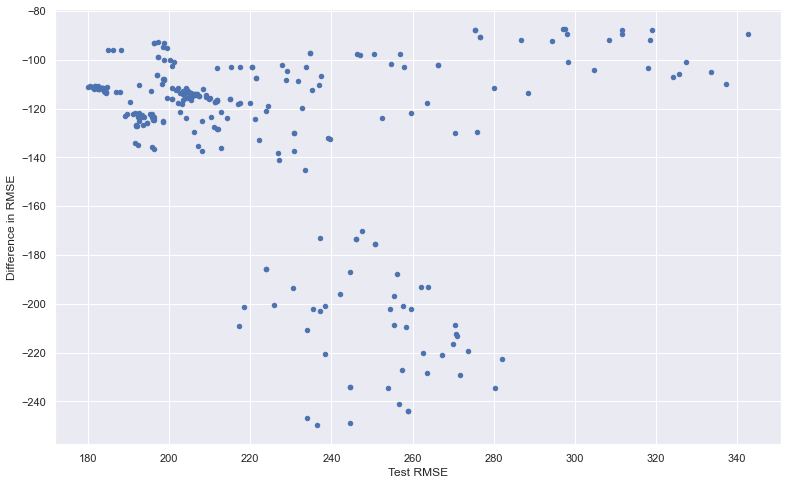

In [236]:
co_gs_results[['Test RMSE', 'Difference in RMSE']].plot(kind='scatter', x='Test RMSE', y='Difference in RMSE')

Based off the grid search, an order of (1, 1, 1) would be most appropriate. Given the lack of seasonal strength, I will pick the (0,0,0,0) seasonal order, given it has a similar RMSE, and lower degree of overfitting

In [171]:
# Hypertune a SARIMAX model
NMHC_ParamGrid = get_param_grid(train, 'NMHC', {
    'p' : range(4),
    'P' : range(4),
    'd' : [0, 1],
    'D' : 0,
    'q' : range(4),
    'Q' : range(4),
    'm' : [0, 7],
    'trend' : ['n', 'c', 'ct'],
    'exog' : [None, train[['T','RH']]]
})

nmhc_gs_results = grid_search(train['NMHC'], 'NMHC', param_grid=NMHC_ParamGrid)
nmhc_gs_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  1.9min finished


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
921  158.854202          -48.833073  (2, 1, 2)   (1, 0, 1, 7)     c   True
811  160.256347          -38.495792  (2, 1, 1)   (1, 0, 1, 7)     n   True
969  160.871934          -55.160925  (2, 1, 2)   (2, 0, 2, 7)     c   True
957  161.740659          -48.527363  (2, 1, 2)   (2, 0, 1, 7)     c   True
501  161.964305          -37.844312  (1, 1, 1)   (1, 0, 2, 7)     c   True
..          ...                 ...        ...            ...   ...    ...
964         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct  False
965         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct   True
966         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     n  False
968         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     c  False
970         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)    ct  False

[972 rows x 6 columns]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Test RMSE', ylabel='Difference in RMSE'>

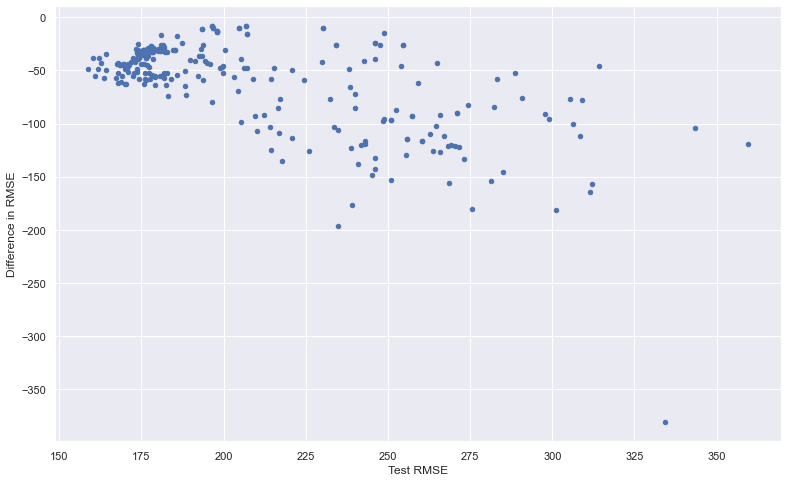

In [226]:
nmhc_gs_results[['Test RMSE', 'Difference in RMSE']].plot(kind='scatter', x='Test RMSE', y='Difference in RMSE')

From looking at the grid search results, it seems that the (2, 1, 1) order (1,0,1,7) seasonal order would be a good fit to the data.

In [172]:
# Hypertune a SARIMAX model
NOx_ParamGrid = get_param_grid(train, 'NOx', {
    'p' : range(4),
    'P' : range(4),
    'd' : [0, 1],
    'D' : [0],
    'q' : range(4),
    'Q' : range(4),
    'm' : [0, 7],
    'trend' : ['n', 'c', 'ct'],
    'exog' : [None, train[['T','RH']]]
})

nox_gs_results = grid_search(train['NOx'], 'NOx', param_grid=NOx_ParamGrid)
nox_gs_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 261 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 558 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  1.8min finished


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
487  168.790109          -63.610038  (1, 1, 1)   (1, 0, 1, 7)     n   True
595  169.587679          -63.863536  (1, 1, 2)   (1, 0, 1, 7)     n   True
919  170.001197          -60.007626  (2, 1, 2)   (1, 0, 1, 7)     n   True
811  170.035630          -68.829117  (2, 1, 1)   (1, 0, 1, 7)     n   True
607  170.833010          -64.935716  (1, 1, 2)   (1, 0, 2, 7)     n   True
..          ...                 ...        ...            ...   ...    ...
964         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct  False
965         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct   True
966         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     n  False
968         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     c  False
970         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)    ct  False

[972 rows x 6 columns]

In [231]:
nox_gs_results[nox_gs_results['Difference in RMSE'] > -50]

Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
649  190.613392          -38.726200  (2, 1, 0)   (0, 0, 0, 0)     n   True
655  190.613392          -38.726200  (2, 1, 0)   (0, 0, 0, 7)     n   True
393  191.031031          -47.407641  (1, 1, 0)   (1, 0, 2, 7)     c   True
91   194.274000          -44.240821  (0, 1, 0)   (2, 0, 1, 7)     n   True
415  195.893326          -47.716646  (1, 1, 0)   (2, 0, 1, 7)     n   True
..          ...                 ...        ...            ...   ...    ...
964         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct  False
965         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct   True
966         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     n  False
968         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     c  False
970         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)    ct  False

[746 rows x 6 columns]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='Test RMSE', ylabel='Difference in RMSE'>

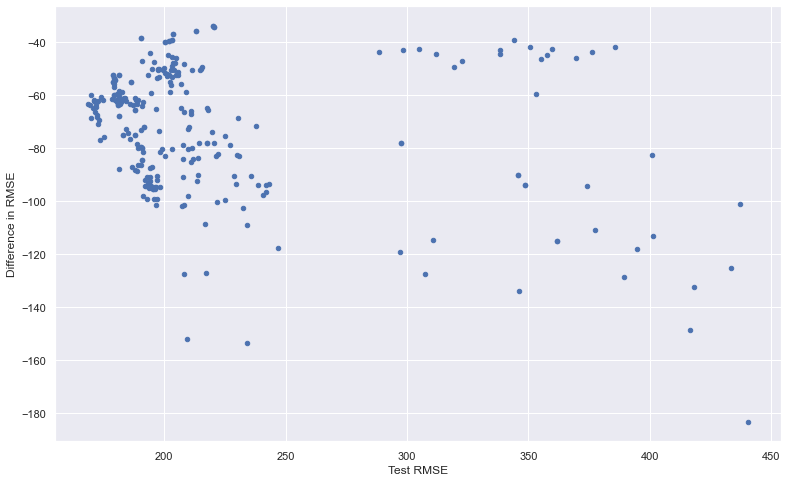

In [227]:
nox_gs_results[['Test RMSE', 'Difference in RMSE']].plot(kind='scatter', x='Test RMSE', y='Difference in RMSE')

Here, we observe the model that appears to generalise well to the data is a (2, 1, 2) order and (1, 0, 1, 7) seasonal order

In [174]:
O3_ParamGrid = get_param_grid(train, 'O3', {
    'p' : range(4),
    'P' : range(4),
    'd' : [0,1],
    'D' : [0],
    'q' : range(4),
    'Q' : range(4),
    'm' : [0, 7],
    'trend' : ['n', 'c', 'ct'],
    'exog' : [None, train[['T','RH']]]
})

o3_gs_results = grid_search(train['O3'], 'O3', param_grid=O3_ParamGrid)
o3_gs_results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 522 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed:  1.9min finished


Test RMSE  Difference in RMSE      Order Seasonal Order Trend  Exog?
487  266.543689         -206.439618  (1, 1, 1)   (1, 0, 1, 7)     n   True
525  284.648159         -203.697432  (1, 1, 1)   (2, 0, 1, 7)     c   True
501  285.683555         -210.318513  (1, 1, 1)   (1, 0, 2, 7)     c   True
609  291.487078         -216.213205  (1, 1, 2)   (1, 0, 2, 7)     c   True
933  292.028290         -206.283773  (2, 1, 2)   (1, 0, 2, 7)     c   True
..          ...                 ...        ...            ...   ...    ...
964         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct  False
965         inf                 inf  (2, 1, 2)   (2, 0, 2, 0)    ct   True
966         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     n  False
968         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)     c  False
970         inf                 inf  (2, 1, 2)   (2, 0, 2, 7)    ct  False

[972 rows x 6 columns]

In this case, it appears a (1, 1, 1) order and (1, 0, 1, 7) seasonal order is the best.

In [180]:
seasonal_orders = {
    "CO" : (0, 0, 0, 0),
    "NMHC" :  (1, 0, 1,7),
    "NOx" :  (1, 0, 1,7),
    "O3" :  (1, 0, 1,7)
}
orders = {
    "CO" : (1, 1, 1),
    "NMHC" : (2, 1, 1),
    "NOx" : (2, 1, 2),
    "O3" : (1, 1, 1)
}

trends = {
    "CO" : 'n',
    "NMHC" :"n",
    "NOx" : "n",
    "O3" : "n"
}
SARIMAX_Results = defaultdict(list)
sarimax_file_names = []

for gas in tqdm(gases):
    order = orders[gas]
    trend = trends[gas]
    seasonal_order = seasonal_orders[gas] if gas in seasonal_orders else None
    exog = train[['T', 'RH']]
    try:
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend})
    except:
        final_model, cv_metrics = eval_model(SARIMAX, train[gas], model_params = {'order' : order, 'seasonal_order' : seasonal_order, 'exog' : exog, 'trend' : trend, 'initialization' : 'approximate_diffuse'})
    SARIMAX_Results[gas] = cv_metrics
    file_name = generate_file_name(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", date=False, location="models/SARIMAX")
    sarimax_file_names.append(file_name)
    final_model.save(file_name)
    history = record_history(f"SARIMAX-{order}-{seasonal_order}-{gas}-{trend}", cv_metrics, gas)
results = parse_results(SARIMAX_Results).describe()

  0%|                                                                                                                                                                                   | 0/4 [00:00<?, ?it/s]C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

C:\Users\tienc\mambaforge\lib\site-package

In [181]:
results.T

count         mean           std          min  \
CO   Corrected AIC         5.0  2037.211427  1.084289e+03   688.664935   
     Train RMSE            5.0   107.569306  1.664745e+01    91.864814   
     Test RMSE             5.0   181.692998  6.345111e+01    89.231396   
     Difference in RMSE    5.0  -110.879493  0.000000e+00  -110.879493   
     Final AICc            5.0  4161.313504  0.000000e+00  4161.313504   
NMHC Corrected AIC         5.0  2030.130640  1.084396e+03   686.767081   
     Train RMSE            5.0   101.781177  1.851743e+01    84.246649   
     Test RMSE             5.0   170.926663  6.723886e+01    88.857857   
     Difference in RMSE    5.0   -38.531855  0.000000e+00   -38.531855   
     Final AICc            5.0  4106.748046  0.000000e+00  4106.748046   
NOx  Corrected AIC         5.0  2075.343165  1.091789e+03   715.901684   
     Train RMSE            5.0   118.503850  1.411648e+01   104.483413   
     Test RMSE             5.0   170.123249  5.260918e+01    86.995545   
     Difference in RMSE    5.0   -60.039645  0.000000e+00   -60.039645   
     Final AICc            5.0  4214.651319  0.000000e+00  4214.651319   
O3   Corrected AIC         5.0  2162.039218  1.114218e+03   766.910391   
     Train RMSE            5.0   162.672398  8.476653e+00   151.911514   
     Test RMSE             5.0   267.015848  7.653707e+01   165.216717   
     Difference in RMSE    5.0  -206.397855  3.177644e-14  -206.397855   
     Final AICc            5.0  4404.127728  0.000000e+00  4404.127728   

                                 25%          50%          75%          max  
CO   Corrected AIC       1356.532533  1972.021125  2750.284351  3418.554191  
     Train RMSE            92.210307   103.709754   124.220025   125.841628  
     Test RMSE            151.792844   189.418626   235.099519   242.922604  
     Difference in RMSE  -110.879493  -110.879493  -110.879493  -110.879493  
     Final AICc          4161.313504  4161.313504  4161.313504  4161.313504  
NMHC Corrected AIC       1347.843204  1954.730156  2748.527242  3412.785517  
     Train RMSE            85.736592    96.057077   120.550674   122.314893  
     Test RMSE            149.123715   159.082529   183.850023   273.719191  
     Difference in RMSE   -38.531855   -38.531855   -38.531855   -38.531855  
     Final AICc          4106.748046  4106.748046  4106.748046  4106.748046  
NOx  Corrected AIC       1396.620768  2021.200969  2755.804274  3487.188130  
     Train RMSE           105.699043   119.064713   124.878032   138.394049  
     Test RMSE            162.974519   174.760379   198.433694   227.452105  
     Difference in RMSE   -60.039645   -60.039645   -60.039645   -60.039645  
     Final AICc          4214.651319  4214.651319  4214.651319  4214.651319  
O3   Corrected AIC       1455.989250  2139.693237  2859.208311  3588.394899  
     Train RMSE           159.297379   160.068492   168.460030   173.624577  
     Test RMSE            237.036180   267.726739   290.241720   374.857885  
     Difference in RMSE  -206.397855  -206.397855  -206.397855  -206.397855  
     Final AICc          4404.127728  4404.127728  4404.127728  4404.127728

In [182]:
history.sort_values(['Gas', 'Mean Test RMSE'])

Model Name  Mean Test RMSE  Difference in RMSE  \
20    SARIMAX-(1, 1, 1)-(0, 0, 0, 0)-CO-n      181.692998         -110.879493   
12                    ARIMAX-(0, 1, 2)-CO      184.244569         -113.127263   
16              SARIMAX-(0, 1, 2)-None-CO      184.244569         -113.127263   
4                      ARIMA-(1, 0, 0)-CO      203.280773         -118.969212   
0                    ExpSmoothingModel-CO      214.046608         -112.255036   
8                SARIMA-(1, 0, 0)-None-CO      270.268912         -167.272746   
21  SARIMAX-(2, 1, 1)-(1, 0, 1, 7)-NMHC-n      170.926663          -38.531855   
5                    ARIMA-(1, 0, 0)-NMHC      176.621412          -48.626404   
13                  ARIMAX-(0, 1, 2)-NMHC      178.563326          -29.007113   
17    SARIMAX-(0, 1, 2)-(0, 0, 3, 7)-NMHC      181.499951          -34.893450   
1                  ExpSmoothingModel-NMHC      184.115621          -18.115312   
9      SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475         -349.124409   
22   SARIMAX-(2, 1, 2)-(1, 0, 1, 7)-NOx-n      170.123249          -60.039645   
14                   ARIMAX-(0, 1, 2)-NOx      179.146555          -53.560119   
6                     ARIMA-(0, 1, 2)-NOx      180.093999          -60.548169   
18     SARIMAX-(0, 1, 2)-(0, 0, 3, 7)-NOx      180.776511          -57.050072   
2                   ExpSmoothingModel-NOx      202.599322          -47.388969   
10      SARIMA-(0, 0, 2)-(0, 0, 3, 7)-NOx      728.337558         -492.665252   
23    SARIMAX-(1, 1, 1)-(1, 0, 1, 7)-O3-n      267.015848         -206.397855   
11       SARIMA-(0, 0, 2)-(4, 0, 0, 7)-O3      284.753751         -203.968888   
7                      ARIMA-(0, 1, 2)-O3      294.898746         -202.790718   
15                    ARIMAX-(0, 1, 2)-O3      306.795922         -181.051099   
19      SARIMAX-(0, 1, 2)-(4, 0, 0, 7)-O3      322.402112         -200.192557   
3                    ExpSmoothingModel-O3      328.276812         -162.787982   

     Final AICc   Gas  
20  4161.313504    CO  
12  4171.243789    CO  
16  4171.243789    CO  
4   4213.796890    CO  
0   3335.346233    CO  
8   4280.269100    CO  
21  4106.748046  NMHC  
5   4188.591376  NMHC  
13  4157.286215  NMHC  
17  4141.853373  NMHC  
1   3315.245757  NMHC  
9   4244.135590  NMHC  
22  4214.651319   NOx  
14  4216.649664   NOx  
6   4221.110015   NOx  
18  4216.582451   NOx  
2   3369.682556   NOx  
10  4565.556459   NOx  
23  4404.127728    O3  
11  4499.145417    O3  
7   4465.960399    O3  
15  4455.726114    O3  
19  4445.768697    O3  
3   3601.976835    O3

#### Using Weekend as Feature

#### Filtering Out Noise in the Data

#### Treatment of Outliers

## Final Model

### Analysis of Order

### Analysis of Residuals

## Generating Kaggle Predictions

In [198]:
test_df = pd.read_csv("test.csv", index_col=0, na_values=[-200])
test_df["Date"] = pd.to_datetime(test_df["Date"], format="%d/%m/%Y")
test_df.index = test_df["Date"]
test_df = test_df.drop("Date", axis=1)

In [199]:
test, missing_days = DataPreprocess(test_df, train=False, remove_outliers=True, impute=True)

### Utility Functions

In [201]:
def generate_csv(test_data, test_preds, missing_days):
    test_preds = np.array(test_preds).flatten()
    submit_df = pd.DataFrame({
    'id' : range(len(test_preds)),
    'Value' : test_preds
})
    # submit_df.iloc[missing_days, 1] = -200 # replace days where sensor records were missing with -200 (NaN)
    submit_df.to_csv(generate_file_name("submission", "csv", "submissions", date=True), index=False)

In [210]:
def generate_submission(models, test, missing_days, refit=True):
    preds = []
    for gas in gases:
        model = load(models[gas])
        data = test[test['Gas'] == gas]
#         data.index = data['Date']
        data = data.asfreq("D")
        forecasts = []
        start, end = data.index[0], data.index[-1]
        if refit:
            for date in pd.date_range(start, end):
                exog = data[['T', 'RH']].loc[date:date]
                try:
                    forecast = model.predict(start=date, exog=exog)
                    forecast.name = gas
                    model = model.append(forecast, exog=exog, refit=True)
                except:
                    forecast = model.predict(start=date)
                    forecast.name = gas
                    model = model.append(forecast, refit=True)
                forecasts.append(forecast)
        else:
            forecast = model.predict(start=start, end=end, exog=data[['T', 'RH']])
        preds.append(forecasts)

    generate_csv(test, preds, missing_days)
    return preds

### Submission

In [207]:
history.sort_values(["Gas", "Mean Test RMSE"])

Model Name  Mean Test RMSE  Difference in RMSE  \
20    SARIMAX-(1, 1, 1)-(0, 0, 0, 0)-CO-n      181.692998         -110.879493   
12                    ARIMAX-(0, 1, 2)-CO      184.244569         -113.127263   
16              SARIMAX-(0, 1, 2)-None-CO      184.244569         -113.127263   
4                      ARIMA-(1, 0, 0)-CO      203.280773         -118.969212   
0                    ExpSmoothingModel-CO      214.046608         -112.255036   
8                SARIMA-(1, 0, 0)-None-CO      270.268912         -167.272746   
21  SARIMAX-(2, 1, 1)-(1, 0, 1, 7)-NMHC-n      170.926663          -38.531855   
5                    ARIMA-(1, 0, 0)-NMHC      176.621412          -48.626404   
13                  ARIMAX-(0, 1, 2)-NMHC      178.563326          -29.007113   
17    SARIMAX-(0, 1, 2)-(0, 0, 3, 7)-NMHC      181.499951          -34.893450   
1                  ExpSmoothingModel-NMHC      184.115621          -18.115312   
9      SARIMA-(1, 0, 0)-(0, 0, 3, 7)-NMHC      489.107475         -349.124409   
22   SARIMAX-(2, 1, 2)-(1, 0, 1, 7)-NOx-n      170.123249          -60.039645   
14                   ARIMAX-(0, 1, 2)-NOx      179.146555          -53.560119   
6                     ARIMA-(0, 1, 2)-NOx      180.093999          -60.548169   
18     SARIMAX-(0, 1, 2)-(0, 0, 3, 7)-NOx      180.776511          -57.050072   
2                   ExpSmoothingModel-NOx      202.599322          -47.388969   
10      SARIMA-(0, 0, 2)-(0, 0, 3, 7)-NOx      728.337558         -492.665252   
23    SARIMAX-(1, 1, 1)-(1, 0, 1, 7)-O3-n      267.015848         -206.397855   
11       SARIMA-(0, 0, 2)-(4, 0, 0, 7)-O3      284.753751         -203.968888   
7                      ARIMA-(0, 1, 2)-O3      294.898746         -202.790718   
15                    ARIMAX-(0, 1, 2)-O3      306.795922         -181.051099   
19      SARIMAX-(0, 1, 2)-(4, 0, 0, 7)-O3      322.402112         -200.192557   
3                    ExpSmoothingModel-O3      328.276812         -162.787982   

     Final AICc   Gas  
20  4161.313504    CO  
12  4171.243789    CO  
16  4171.243789    CO  
4   4213.796890    CO  
0   3335.346233    CO  
8   4280.269100    CO  
21  4106.748046  NMHC  
5   4188.591376  NMHC  
13  4157.286215  NMHC  
17  4141.853373  NMHC  
1   3315.245757  NMHC  
9   4244.135590  NMHC  
22  4214.651319   NOx  
14  4216.649664   NOx  
6   4221.110015   NOx  
18  4216.582451   NOx  
2   3369.682556   NOx  
10  4565.556459   NOx  
23  4404.127728    O3  
11  4499.145417    O3  
7   4465.960399    O3  
15  4455.726114    O3  
19  4445.768697    O3  
3   3601.976835    O3

In [212]:
models = {
    "CO" : "models/SARIMAX/SARIMAX-(1, 1, 1)-(0, 0, 0, 0)-CO-n.pkl",
    "NMHC" : "models/SARIMAX/SARIMAX-(2, 1, 1)-(1, 0, 1, 7)-NMHC-n.pkl",
    "NOx" : "models/SARIMAX/SARIMAX-(2, 1, 2)-(1, 0, 1, 7)-NOx-n.pkl",
    "O3" : "models/SARIMAX/SARIMAX-(1, 1, 1)-(1, 0, 1, 7)-O3-n.pkl"
}

In [213]:
preds = generate_submission(models, test, missing_days)

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\tienc\mambaforge\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



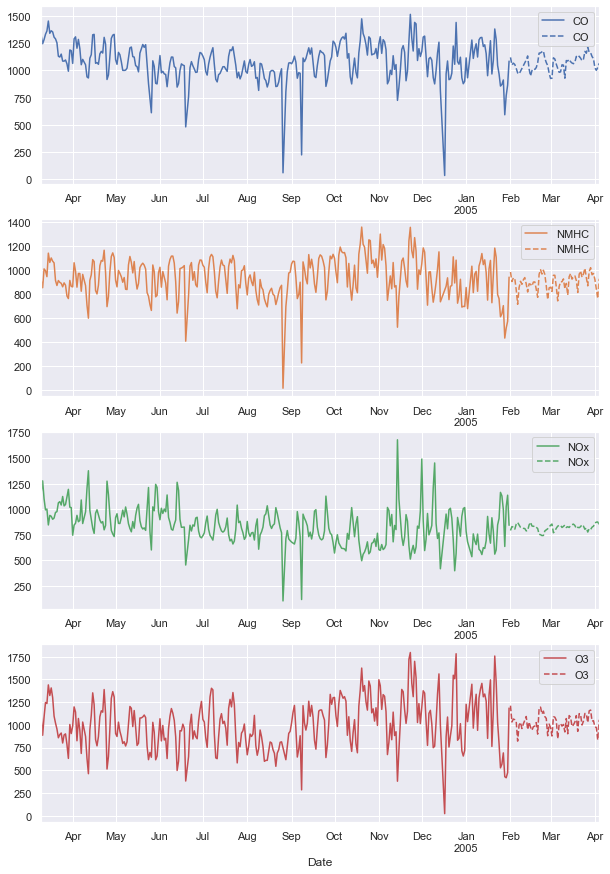

In [214]:
def plot_predictions(data, preds):
    fig, ax = plt.subplots(4, 1, figsize=(10, 15))
    preds_df = pd.DataFrame({
    pd.concat(series).name : pd.concat(series) for series in preds
})
    data[['CO', 'NMHC', 'NOx', 'O3']].plot(subplots=True, ax=ax)
    preds_df.plot(subplots=True, ax =ax, style='--')
plot_predictions(train, preds)